<a href="https://colab.research.google.com/github/krishna1194/BitCoinPrediction/blob/main/BitCoinPrediction_Closing_Value.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Time series analysis**

## Time series analysis and Transforms - Overview

We perform in our time series in order to get some insights or transform the series to make forecasting easier.

Time series decomposition

*   Level
*   Trend
*   Seasonality
*   Noise

Stationarity

*   AC and PAC plots
*   Rolling mean and std
*   Dickey-Fuller test

Making our time series stationary

*   Difference transform
*   Log scale
*   Smoothing
*   Moving average

## Importing functions

In [ ]:
!pip install pmdarima
!pip install shap
!pip install bayesian-optimization
!pip install gluonts
!pip install mxnet
!pip install python-utils
!pip install cryptocmd

In [ ]:
import warnings
from math import sqrt

import lightgbm as lgb
import matplotlib as mpl
import numpy as np
import pandas as pd  # Basic library for all of our dataset operations
import pmdarima as pm
import shap
import statsmodels as sm
import tensorflow as tf
import xgboost as xgb
from bayes_opt import BayesianOptimization
from fbprophet import Prophet
from gluonts.dataset.common import ListDataset
from gluonts.evaluation.backtest import make_evaluation_predictions
from gluonts.model.deepar import DeepAREstimator
from gluonts.mx.trainer import Trainer
from matplotlib import pyplot as plt
from pylab import rcParams
from sklearn import linear_model, svm
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa import api as smt
from statsmodels.tsa.ar_model import AR
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.holtwinters import ExponentialSmoothing, SimpleExpSmoothing
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from tqdm import tqdm


# We will use deprecated models of statmodels which throw a lot of warnings to use more modern ones
warnings.filterwarnings("ignore")


# Extra settings
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)
plt.style.use('bmh')
mpl.rcParams['axes.labelsize'] = 14
mpl.rcParams['xtick.labelsize'] = 12
mpl.rcParams['ytick.labelsize'] = 12
mpl.rcParams['text.color'] = 'k'
print(tf.__version__)

Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.


2.7.0


In [ ]:
#Evaluation Metrics

import numpy as np
from sklearn.metrics import r2_score

EPSILON = 1e-10


def _error(actual: np.ndarray, predicted: np.ndarray):
    """Simple error"""
    return actual - predicted


def _percentage_error(actual: np.ndarray, predicted: np.ndarray):
    """
    Percentage error
    Note: result is NOT multiplied by 100
    """
    return _error(actual, predicted) / (actual + EPSILON)


def _naive_forecasting(actual: np.ndarray, seasonality: int = 1):
    """Naive forecasting method which just repeats previous samples"""
    return actual[:-seasonality]


def _relative_error(
    actual: np.ndarray, predicted: np.ndarray, benchmark: np.ndarray = None
):
    """Relative Error"""
    if benchmark is None or isinstance(benchmark, int):
        # If no benchmark prediction provided - use naive forecasting
        if not isinstance(benchmark, int):
            seasonality = 1
        else:
            seasonality = benchmark
        return _error(actual[seasonality:], predicted[seasonality:]) / (
            _error(actual[seasonality:], _naive_forecasting(actual, seasonality))
            + EPSILON
        )

    return _error(actual, predicted) / (_error(actual, benchmark) + EPSILON)


def _bounded_relative_error(
    actual: np.ndarray, predicted: np.ndarray, benchmark: np.ndarray = None
):
    """Bounded Relative Error"""
    if benchmark is None or isinstance(benchmark, int):
        # If no benchmark prediction provided - use naive forecasting
        if not isinstance(benchmark, int):
            seasonality = 1
        else:
            seasonality = benchmark

        abs_err = np.abs(_error(actual[seasonality:], predicted[seasonality:]))
        abs_err_bench = np.abs(
            _error(actual[seasonality:], _naive_forecasting(actual, seasonality))
        )
    else:
        abs_err = np.abs(_error(actual, predicted))
        abs_err_bench = np.abs(_error(actual, benchmark))

    return abs_err / (abs_err + abs_err_bench + EPSILON)


def _geometric_mean(a, axis=0, dtype=None):
    """Geometric mean"""
    if not isinstance(a, np.ndarray):  # if not an ndarray object attempt to convert it
        log_a = np.log(np.array(a, dtype=dtype))
    elif dtype:  # Must change the default dtype allowing array type
        if isinstance(a, np.ma.MaskedArray):
            log_a = np.log(np.ma.asarray(a, dtype=dtype))
        else:
            log_a = np.log(np.asarray(a, dtype=dtype))
    else:
        log_a = np.log(a)
    return np.exp(log_a.mean(axis=axis))


def mse(actual: np.ndarray, predicted: np.ndarray):
    """Mean Squared Error"""
    return np.mean(np.square(_error(actual, predicted)))


def rmse(actual: np.ndarray, predicted: np.ndarray):
    """Root Mean Squared Error"""
    return np.sqrt(mse(actual, predicted))


def nrmse(actual: np.ndarray, predicted: np.ndarray):
    """Normalized Root Mean Squared Error"""
    return rmse(actual, predicted) / (actual.max() - actual.min())


def me(actual: np.ndarray, predicted: np.ndarray):
    """Mean Error"""
    return np.mean(_error(actual, predicted))


def mae(actual: np.ndarray, predicted: np.ndarray):
    """Mean Absolute Error"""
    return np.mean(np.abs(_error(actual, predicted)))


mad = mae  # Mean Absolute Deviation (it is the same as MAE)


def gmae(actual: np.ndarray, predicted: np.ndarray):
    """Geometric Mean Absolute Error"""
    return _geometric_mean(np.abs(_error(actual, predicted)))


def mdae(actual: np.ndarray, predicted: np.ndarray):
    """Median Absolute Error"""
    return np.median(np.abs(_error(actual, predicted)))


def mpe(actual: np.ndarray, predicted: np.ndarray):
    """Mean Percentage Error"""
    return np.mean(_percentage_error(actual, predicted))


def mape(actual: np.ndarray, predicted: np.ndarray):
    """
    Mean Absolute Percentage Error
    Properties:
        + Easy to interpret
        + Scale independent
        - Biased, not symmetric
        - Undefined when actual[t] == 0
    Note: result is NOT multiplied by 100
    """
    return np.mean(np.abs(_percentage_error(actual, predicted)))


def mdape(actual: np.ndarray, predicted: np.ndarray):
    """
    Median Absolute Percentage Error
    Note: result is NOT multiplied by 100
    """
    return np.median(np.abs(_percentage_error(actual, predicted)))


def smape(actual: np.ndarray, predicted: np.ndarray):
    """
    Symmetric Mean Absolute Percentage Error
    Note: result is NOT multiplied by 100
    """
    return np.mean(
        2.0
        * np.abs(actual - predicted)
        / ((np.abs(actual) + np.abs(predicted)) + EPSILON)
    )


def smdape(actual: np.ndarray, predicted: np.ndarray):
    """
    Symmetric Median Absolute Percentage Error
    Note: result is NOT multiplied by 100
    """
    return np.median(
        2.0
        * np.abs(actual - predicted)
        / ((np.abs(actual) + np.abs(predicted)) + EPSILON)
    )


def maape(actual: np.ndarray, predicted: np.ndarray):
    """
    Mean Arctangent Absolute Percentage Error
    Note: result is NOT multiplied by 100
    """
    return np.mean(np.arctan(np.abs((actual - predicted) / (actual + EPSILON))))


def mase(actual: np.ndarray, predicted: np.ndarray, seasonality: int = 1):
    """
    Mean Absolute Scaled Error
    Baseline (benchmark) is computed with naive forecasting (shifted by @seasonality)
    """
    return mae(actual, predicted) / mae(
        actual[seasonality:], _naive_forecasting(actual, seasonality)
    )


def std_ae(actual: np.ndarray, predicted: np.ndarray):
    """Normalized Absolute Error"""
    __mae = mae(actual, predicted)
    return np.sqrt(
        np.sum(np.square(_error(actual, predicted) - __mae)) / (len(actual) - 1)
    )


def std_ape(actual: np.ndarray, predicted: np.ndarray):
    """Normalized Absolute Percentage Error"""
    __mape = mape(actual, predicted)
    return np.sqrt(
        np.sum(np.square(_percentage_error(actual, predicted) - __mape))
        / (len(actual) - 1)
    )


def rmspe(actual: np.ndarray, predicted: np.ndarray):
    """
    Root Mean Squared Percentage Error
    Note: result is NOT multiplied by 100
    """
    return np.sqrt(np.mean(np.square(_percentage_error(actual, predicted))))


def rmdspe(actual: np.ndarray, predicted: np.ndarray):
    """
    Root Median Squared Percentage Error
    Note: result is NOT multiplied by 100
    """
    return np.sqrt(np.median(np.square(_percentage_error(actual, predicted))))


def rmsse(actual: np.ndarray, predicted: np.ndarray, seasonality: int = 1):
    """Root Mean Squared Scaled Error"""
    q = np.abs(_error(actual, predicted)) / mae(
        actual[seasonality:], _naive_forecasting(actual, seasonality)
    )
    return np.sqrt(np.mean(np.square(q)))


def inrse(actual: np.ndarray, predicted: np.ndarray):
    """Integral Normalized Root Squared Error"""
    return np.sqrt(
        np.sum(np.square(_error(actual, predicted)))
        / np.sum(np.square(actual - np.mean(actual)))
    )


def rrse(actual: np.ndarray, predicted: np.ndarray):
    """Root Relative Squared Error"""
    return np.sqrt(
        np.sum(np.square(actual - predicted))
        / np.sum(np.square(actual - np.mean(actual)))
    )


def mre(actual: np.ndarray, predicted: np.ndarray, benchmark: np.ndarray = None):
    """Mean Relative Error"""
    return np.mean(_relative_error(actual, predicted, benchmark))


def rae(actual: np.ndarray, predicted: np.ndarray):
    """Relative Absolute Error (aka Approximation Error)"""
    return np.sum(np.abs(actual - predicted)) / (
        np.sum(np.abs(actual - np.mean(actual))) + EPSILON
    )


def mrae(actual: np.ndarray, predicted: np.ndarray, benchmark: np.ndarray = None):
    """Mean Relative Absolute Error"""
    return np.mean(np.abs(_relative_error(actual, predicted, benchmark)))


def mdrae(actual: np.ndarray, predicted: np.ndarray, benchmark: np.ndarray = None):
    """Median Relative Absolute Error"""
    return np.median(np.abs(_relative_error(actual, predicted, benchmark)))


def gmrae(actual: np.ndarray, predicted: np.ndarray, benchmark: np.ndarray = None):
    """Geometric Mean Relative Absolute Error"""
    return _geometric_mean(np.abs(_relative_error(actual, predicted, benchmark)))


def mbrae(actual: np.ndarray, predicted: np.ndarray, benchmark: np.ndarray = None):
    """Mean Bounded Relative Absolute Error"""
    return np.mean(_bounded_relative_error(actual, predicted, benchmark))


def umbrae(actual: np.ndarray, predicted: np.ndarray, benchmark: np.ndarray = None):
    """Unscaled Mean Bounded Relative Absolute Error"""
    __mbrae = mbrae(actual, predicted, benchmark)
    return __mbrae / (1 - __mbrae)


def mda(actual: np.ndarray, predicted: np.ndarray):
    """Mean Directional Accuracy"""
    return np.mean(
        (
            np.sign(actual[1:] - actual[:-1]) == np.sign(predicted[1:] - predicted[:-1])
        ).astype(int)
    )


def bias(actual: np.ndarray, predicted: np.ndarray):
    """Mean forecast error(or Forecast Bias)"""
    return np.mean(actual - predicted)


METRICS = {
    "mse": mse,
    "rmse": rmse,
    "nrmse": nrmse,
    "me": me,
    "mae": mae,
    "mad": mad,
    "gmae": gmae,
    "mdae": mdae,
    "mpe": mpe,
    "mape": mape,
    "mdape": mdape,
    "smape": smape,
    "smdape": smdape,
    "maape": maape,
    "mase": mase,
    "std_ae": std_ae,
    "std_ape": std_ape,
    "rmspe": rmspe,
    "rmdspe": rmdspe,
    "rmsse": rmsse,
    "inrse": inrse,
    "rrse": rrse,
    "mre": mre,
    "rae": rae,
    "mrae": mrae,
    "mdrae": mdrae,
    "gmrae": gmrae,
    "mbrae": mbrae,
    "umbrae": umbrae,
    "mda": mda,
    "bias": bias,
    "r2": r2_score,
}


def evaluate(
    actual: np.ndarray, predicted: np.ndarray, metrics=("mae", "rmse", "mape", "r2")
):
    results = {}
    for name in metrics:
        try:
            results[name] = METRICS[name](actual, predicted)
        except Exception as err:
            results[name] = np.nan
            print("Unable to compute metric {0}: {1}".format(name, err))
    return results


def evaluate_all(actual: np.ndarray, predicted: np.ndarray):
    return evaluate(actual, predicted, metrics=set(METRICS.keys()))

In [ ]:
#Plots

import matplotlib.pyplot as plt
import pandas as pd


def bar_metrics(resultsDict):
    df = pd.DataFrame.from_dict(resultsDict)
    colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]
    pallette = plt.cm.get_cmap("tab20c", len(df.columns))
    colors = [pallette(x) for x in range(len(df.columns))]
    color_dict = dict(zip(df.columns, colors))
    fig = plt.figure(figsize=(20, 15))

    # MAE plot
    fig.add_subplot(2, 2, 1)
    df.loc["mae"].sort_values().plot(
        kind="bar",
        colormap="Paired",
        color=[color_dict.get(x, "#333333") for x in df.loc["mae"].sort_values().index],
    )
    plt.legend()
    plt.title("MAE Metric, lower is better")
    fig.add_subplot(2, 2, 2)
    df.loc["rmse"].sort_values().plot(
        kind="bar",
        colormap="Paired",
        color=[
            color_dict.get(x, "#333333") for x in df.loc["rmse"].sort_values().index
        ],
    )
    plt.legend()
    plt.title("RMSE Metric, lower is better")
    fig.add_subplot(2, 2, 3)
    df.loc["mape"].sort_values().plot(
        kind="bar",
        colormap="Paired",
        color=[
            color_dict.get(x, "#333333") for x in df.loc["mape"].sort_values().index
        ],
    )
    plt.legend()
    plt.title("MAPE Metric, lower is better")
    fig.add_subplot(2, 2, 4)
    df.loc["r2"].sort_values(ascending=False).plot(
        kind="bar",
        colormap="Paired",
        color=[
            color_dict.get(x, "#333333")
            for x in df.loc["r2"].sort_values(ascending=False).index
        ],
    )
    plt.legend()
    plt.title("R2 Metric, higher is better")
    plt.tight_layout()
    # plt.savefig("results/metrics.png")
    plt.show()

## Load Data

In [ ]:
from cryptocmd import CmcScraper

In [ ]:
# initialise scraper without time interval
scraper = CmcScraper("BTC")
# get raw data as list of list
headers, data = scraper.get_data()
# get data in a json format
xrp_json_data = scraper.get_data("json")
# Pandas dataFrame for the same data
df_full = scraper.get_dataframe()
df_full['Date'] =  pd.to_datetime(df_full['Date'])

In [ ]:
# df = df_full[(df_full['Date'].dt.year >= 2017) & (df_full['Date'].dt.year <= 2021)]
df = df_full[(df_full['Date'].dt.year == 2020) | (df_full['Date'].dt.year == 2021)]
df_til_21 = df_full[df_full['Date'].dt.year != 2022]

In [ ]:
df.index = df.Date
df.drop('Date',axis=1,inplace=True)

In [ ]:
df.shape

(731, 6)

## Feature Engineering and EDA

### Basic EDA

In [ ]:
# Typical_Price : [(H+L+C)/3]
df["Typical_Price"] = (df.High + df.Low + df.Close) / 3
# Typical Price by Volume: Typical_Price*Volume
df["TP_by_Volume"] = df.Typical_Price * df.Volume
# Weighted_Price: VWAP- Volume Weighted Average Price
df["Weighted_Price"] = df.TP_by_Volume.cumsum() / df.Volume.cumsum()

In [ ]:
df.describe()

Open          High  ...  TP_by_Volume  Weighted_Price
count    731.000000    731.000000  ...  7.310000e+02      731.000000
mean   29204.591439  30008.057476  ...  1.302434e+15    44854.540423
std    19693.542334  20227.104351  ...  1.279572e+15     6723.593012
min     5002.578138   5331.833860  ...  1.121282e+14    32495.979068
25%     9695.668321   9852.802937  ...  3.113219e+14    39241.770733
50%    28841.573758  29244.876688  ...  8.935611e+14    46648.617164
75%    47790.846197  49175.048346  ...  1.986929e+15    49588.140829
max    67549.735581  68789.625939  ...  1.628086e+16    56853.352213

[8 rows x 9 columns]

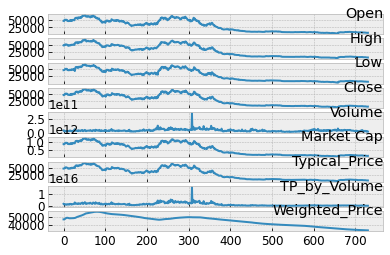

In [ ]:
# Lets check each feature values

values = df.values
groups = [0, 1, 2, 3, 4, 5, 6, 7,8]
i = 1
# plot each column
for group in groups:
    plt.subplot(len(groups), 1, i)
    plt.plot(values[:, group])
    plt.title(df.columns[group], y=0.5, loc='right')
    i += 1


plt.show()

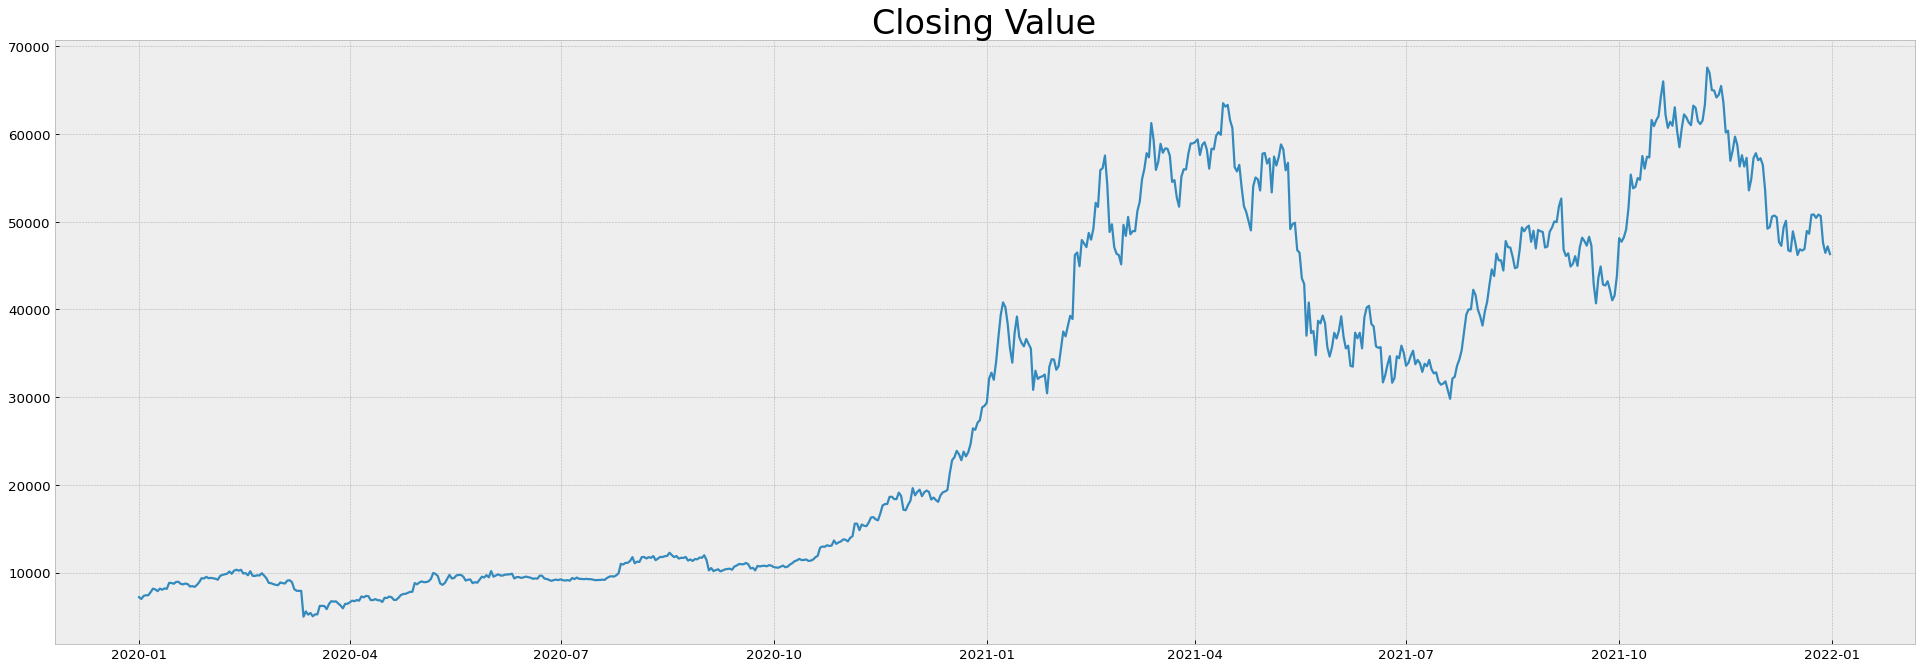

In [ ]:
plt.figure(num=None, figsize=(30, 10), dpi=80, facecolor='w', edgecolor='k')
plt.title('Closing Value', fontsize=30)

plt.plot(df.Close)

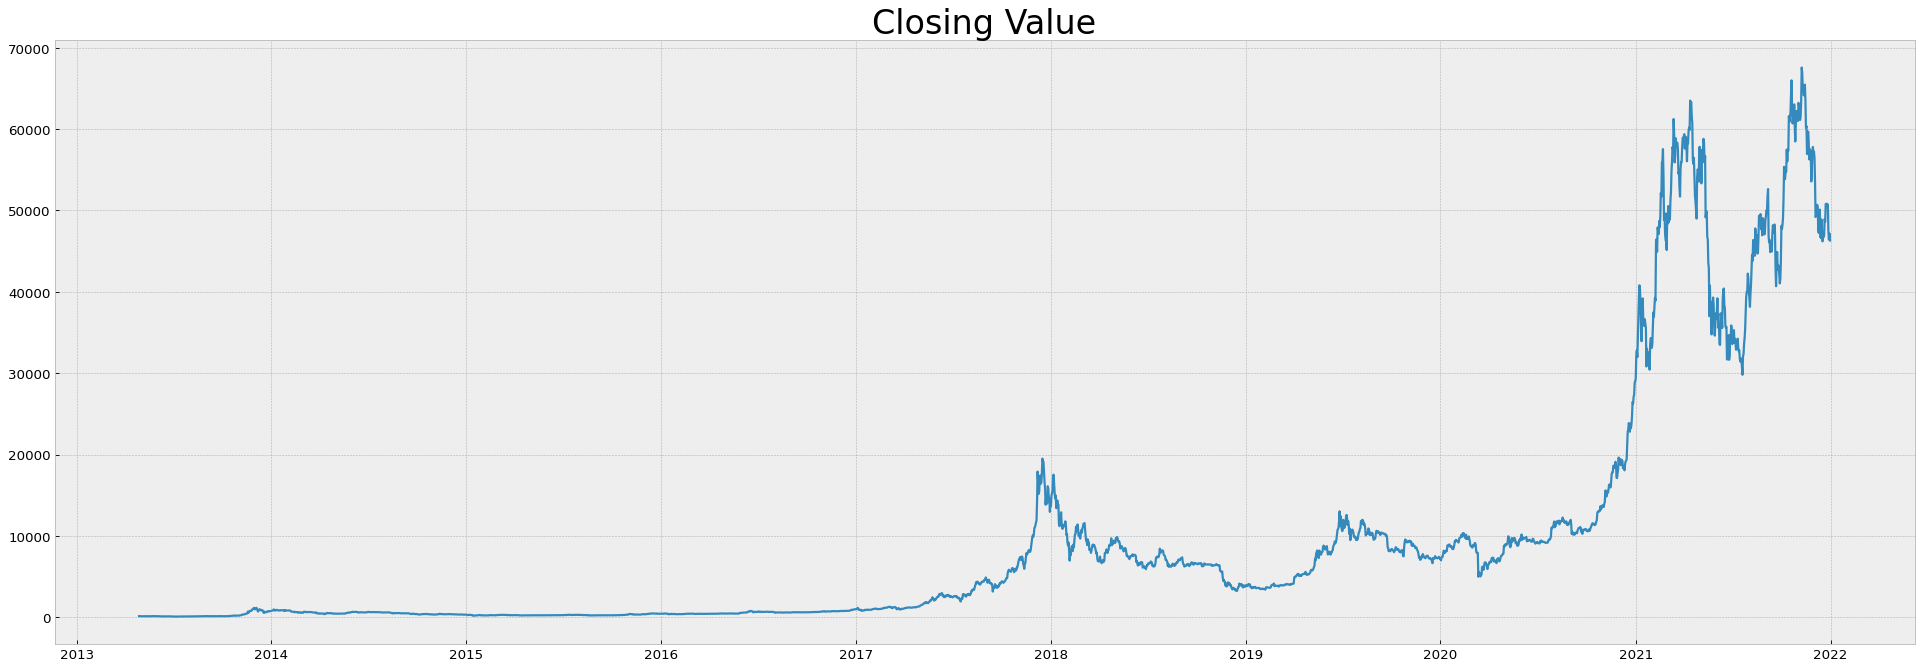

In [ ]:
# Full Data - Till 2021
plt.figure(num=None, figsize=(30, 10), dpi=80, facecolor='w', edgecolor='k')
plt.title('Closing Value', fontsize=30)

df_til_21.index = df_til_21.Date
df_til_21.drop('Date',axis=1,inplace=True)
plt.plot(df_til_21.Close)

### Decomposing our time series

One of the most common analysis for time series is decomposing it into multiple parts. The parts we can divide a time series into are: level, trend, seasonality and noise, all series contain level and noise but seasonality and trend are not always present (there will be more analysis for this two parts).

This 4 parts can combine either additively or multiplicatively into the time series.

**Additive Model**

y(t) = Level + Trend + Seasonality + Noise

Additives models are lineal. Trend is linear and seasonality has constant frequency and amplitude. Change is constant over time

**Multiplicative model**

y(t) = Level * Trend * Seasonality * Noise

Multiplicatives models are nonlinear,trend is curved and seasonality is not constant. Change is not constant over time

Decomposing is used to analyse the time series. Identify each one of the different parts of the time series and its behaviour, each of the components may affect your models in different ways.

Most time series are a combination of a additive model and a multiplicate model, is hard to identify real world time series into one single model.

**Automatic time series decomposition**

Statsmodel python library provides a function [seasonal_compose()](https://www.statsmodels.org/dev/generated/statsmodels.tsa.seasonal.seasonal_decompose.html) to automatically decompose a time series, you still need to specify wether the model is additive or multiplicative.

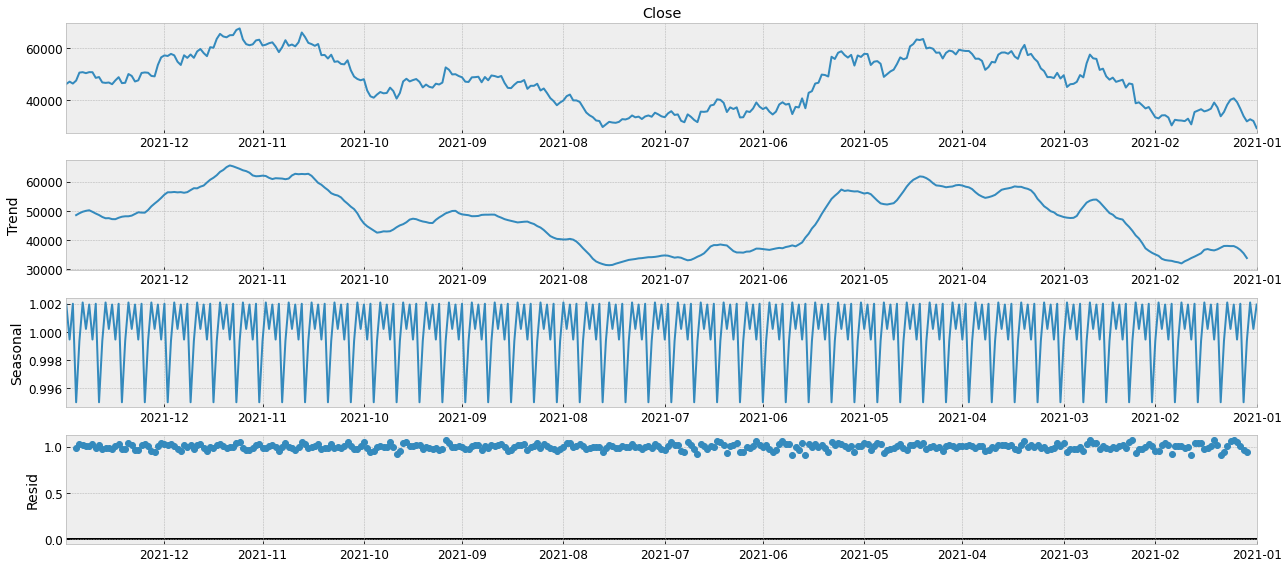

<Figure size 4000x1600 with 0 Axes>

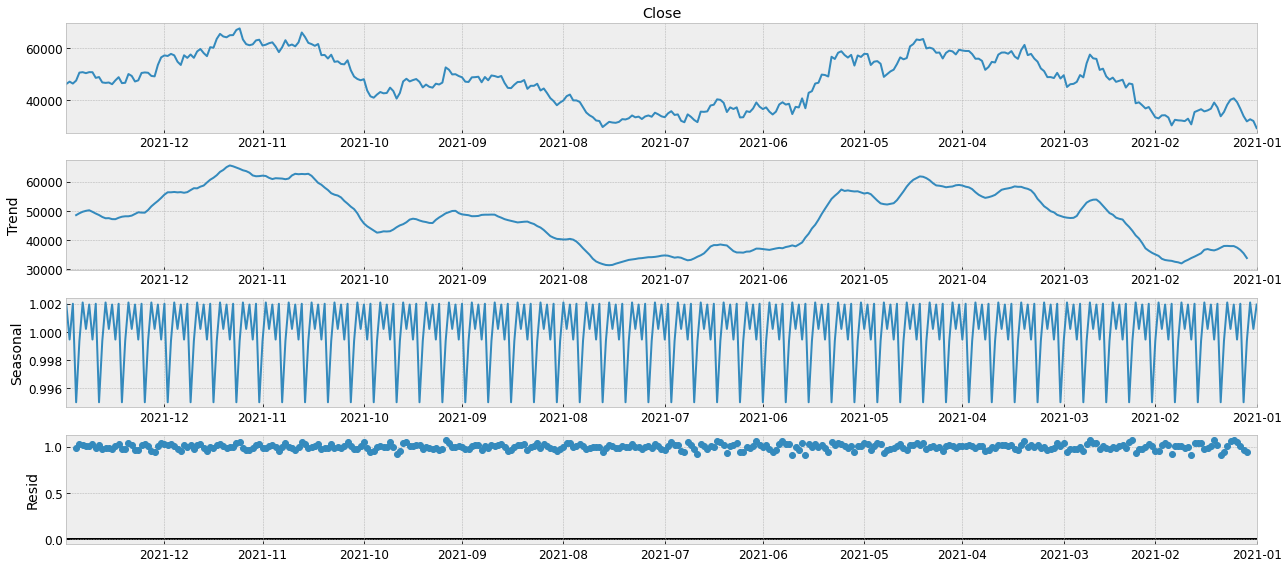

In [ ]:
rcParams['figure.figsize'] = 18, 8
plt.figure(num=None, figsize=(50, 20), dpi=80, facecolor='w', edgecolor='k')
series = df.Close[:365]
result = seasonal_decompose(series, model='multiplicative')
result.plot()

#### **Level**

Level simply means the current value of the series once we remove trend, seasonality and the random noise. This are the true values that come from the series itself and we will try to predict with our models. Most of the models will benefit the more our time series is composed by the level and not trends/seasonality/noise. We also present models capable of handling seasonality and trend (non stationary series)

##### **Trend**

A trend is observed when there is an increasing or decreasing slope observed in the time series. A trend is a smooth, general, long-term,average tendency. It is not always necessary that the increase or decrease is in the same direction throughout the given period of time.

Trend can be removed from your time series data (and data in the future) as a data preparation and cleaning exercise. This is common when using statistical methods for time series forecasting, but does not always improve results when using machine learning models. We will see different methods for this in the making your series stationary section

In practice, identifying a trend in a time series can be a subjective process as we are never sure if contains seasonalities or noise to it, Create line plots of your data and inspect the plots for obvious trends.

Now we will try some methods to check for trend in our series:


*   Automatic decomposing
*   Moving average
*   Fit a linear regression model to identify trend

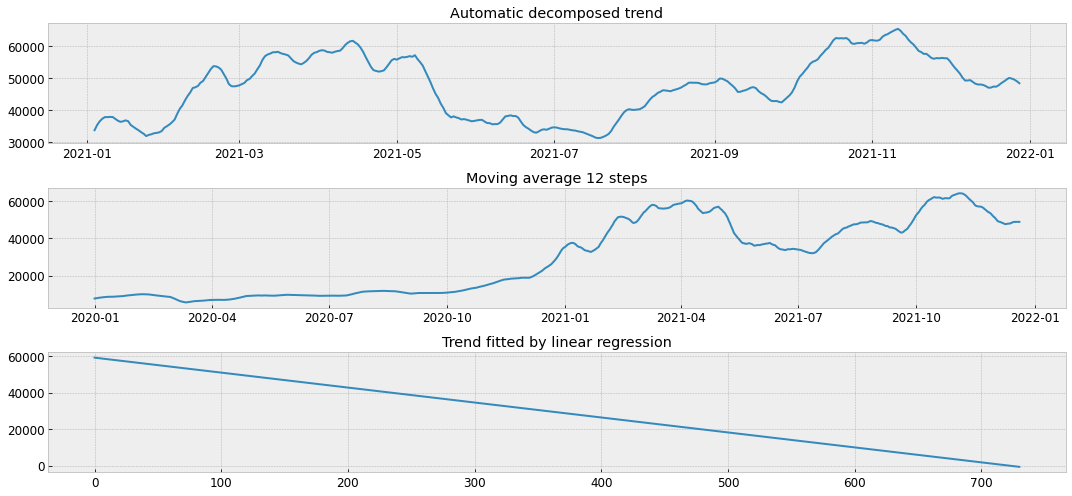

In [ ]:
fig = plt.figure(figsize=(15, 7))
layout = (3, 2)
pm_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
mv_ax = plt.subplot2grid(layout, (1, 0), colspan=2)
fit_ax = plt.subplot2grid(layout, (2, 0), colspan=2)

pm_ax.plot(result.trend)
pm_ax.set_title("Automatic decomposed trend")

mm = df.Close.rolling(12).mean()
mv_ax.plot(mm)
mv_ax.set_title("Moving average 12 steps")


X = [i for i in range(0, len(df.Close))]
X = np.reshape(X, (len(X), 1))
y = df.Close.values
model = LinearRegression()
model.fit(X, y)
# calculate trend
trend = model.predict(X)
fit_ax.plot(trend)
fit_ax.set_title("Trend fitted by linear regression")

plt.tight_layout()

We can see our series does not have a strong trend, results from both the automatic decomposition and the moving average look more like a seasonality efect+random noise than a trend. This sort of confirmed with our linear regression, which cant find our series properly and gives us a poor trend.

We could also try to split our series into smaller ones to try identify subtrends with the mentioned methods but we will not be doing so in this section.

##### **Seasonality**

Seasonality is observed when there is a distinct repeated pattern observed between regular intervals due to seasonal factors. It could be because of the month of the year, the day of the month, weekdays or even time of the day. For example the amount of sales of Ice Cream (always low in winter and high in summer).

The automatic decomposing chart did not gave us a good look into the decomposed seasonality, let's try decomposing smaller parts of the time series first and test seasonalities we found into the others.

Lets go with the latest year of data only now:

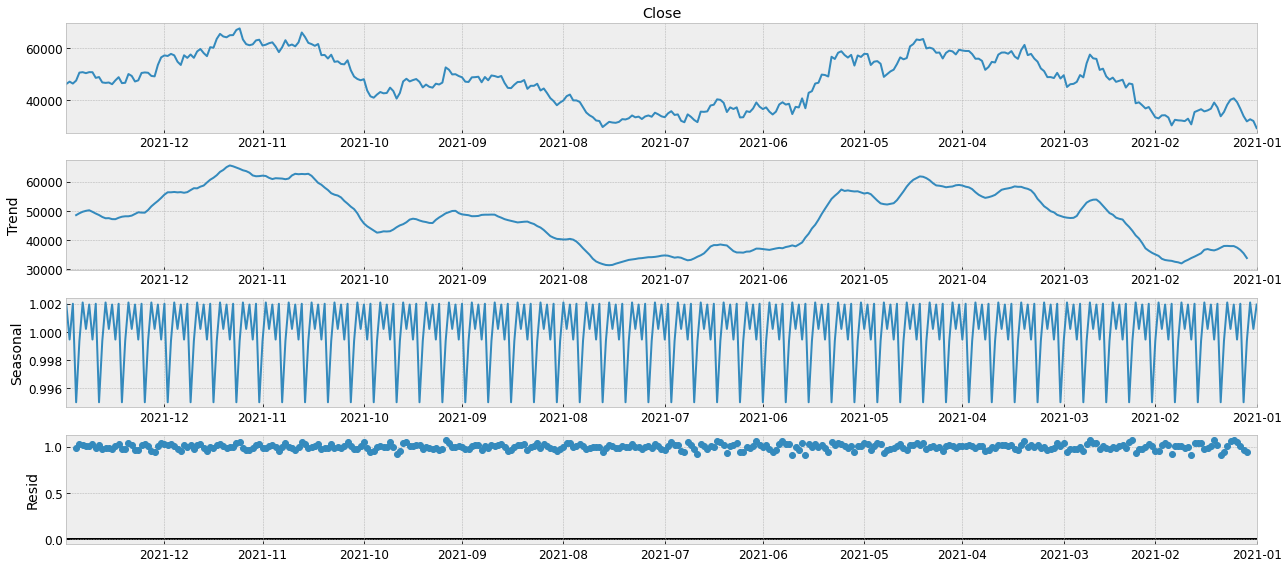

<Figure size 4000x1600 with 0 Axes>

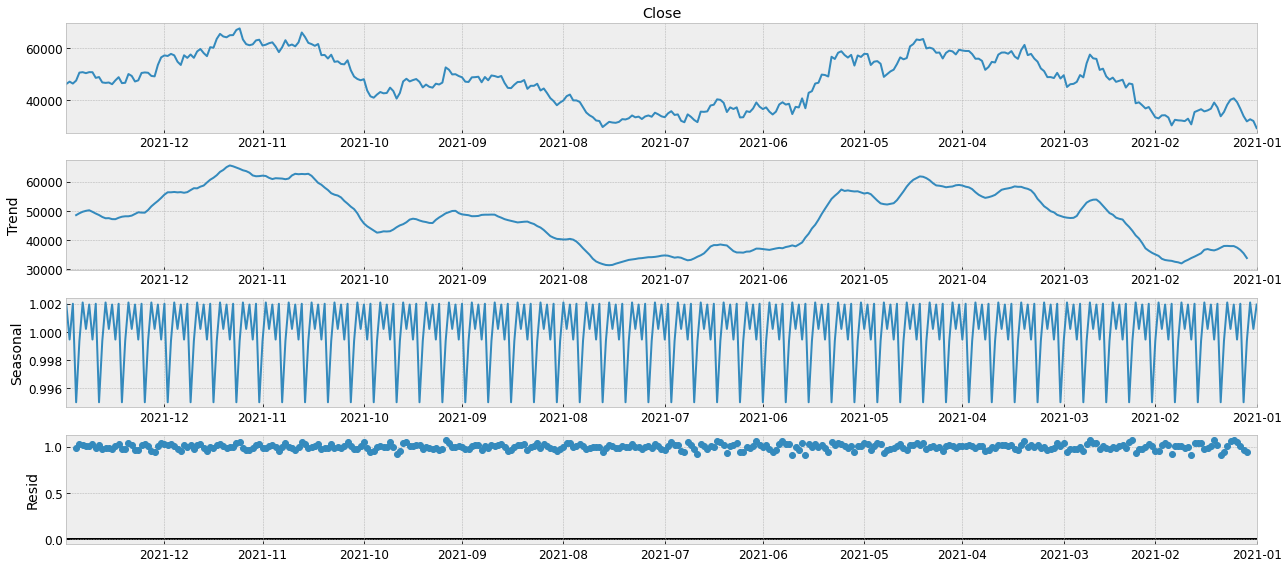

In [ ]:
rcParams['figure.figsize'] = 18, 8
plt.figure(num=None, figsize=(50, 20), dpi=80, facecolor='w', edgecolor='k')
series = df.Close[:365]
result = seasonal_decompose(series, model='multiplicative')
result.plot()

We still have to do some check

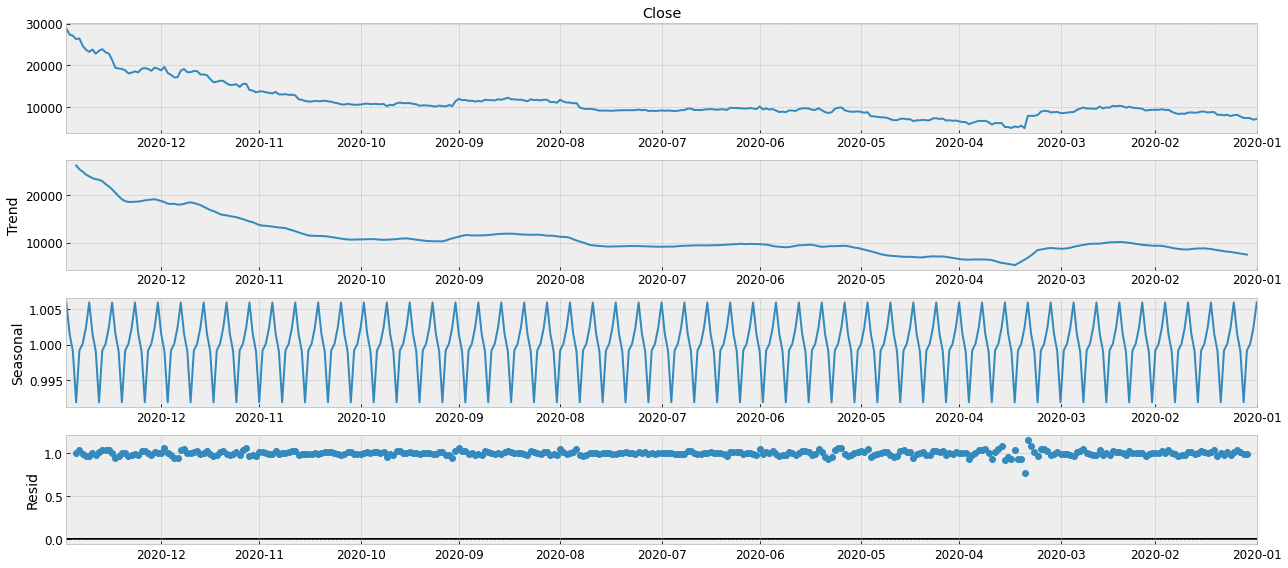

<Figure size 4000x1600 with 0 Axes>

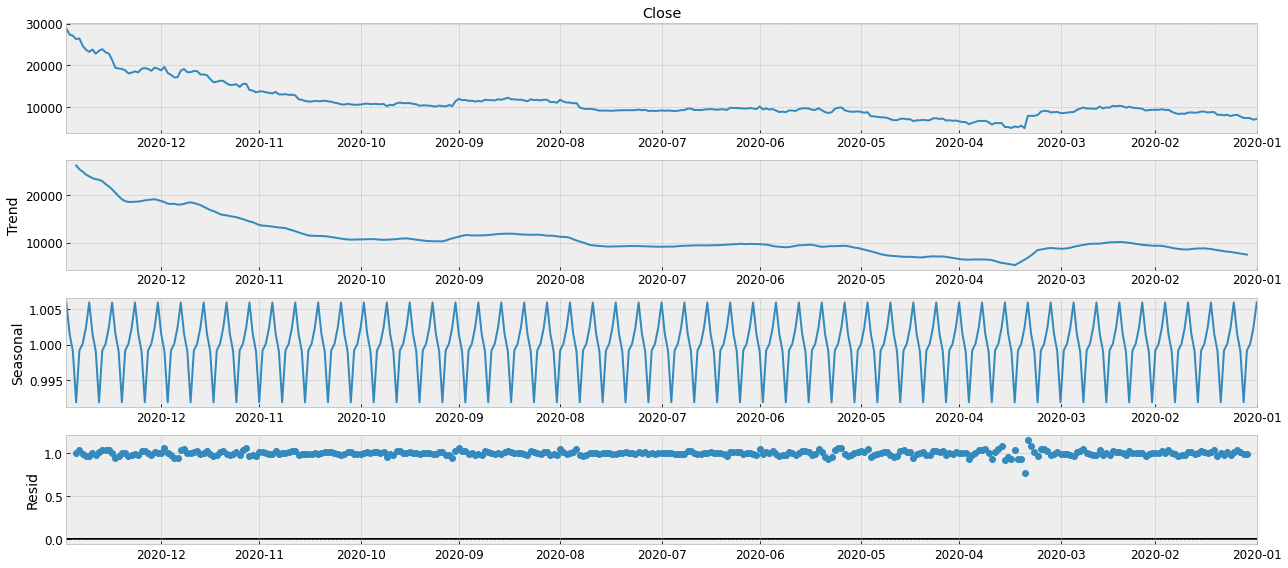

In [ ]:
rcParams['figure.figsize'] = 18, 8
plt.figure(num=None, figsize=(50, 20), dpi=80, facecolor='w', edgecolor='k')
series = df.Close[-365:]
result = seasonal_decompose(series, model='multiplicative')
result.plot()

### Interpretation

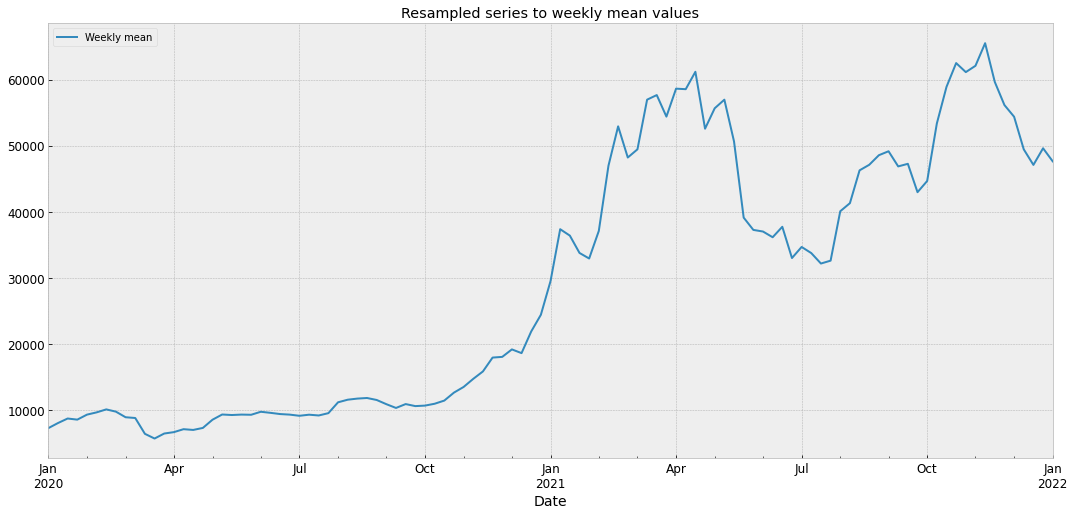

In [ ]:
# Looking for weekly seasonality
resample = df.resample('W')
weekly_mean = resample.mean()
weekly_mean.Close.plot(label='Weekly mean')
plt.title("Resampled series to weekly mean values")
plt.legend()

#### **Seasonalities**

**Manual methods to find seasonalities**

We can also try to generate a model to find the seasonalities for us. One of the most common to use is a simple polynomial model.

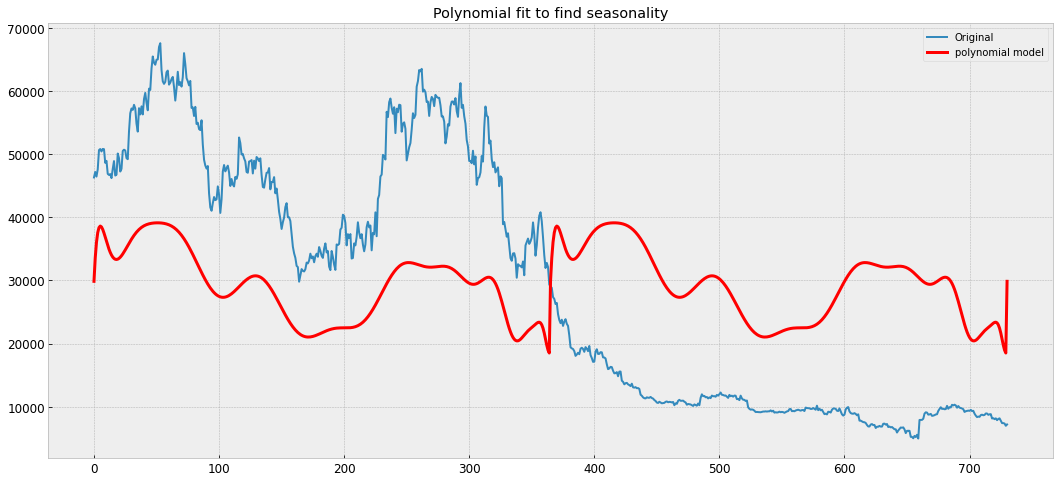

In [ ]:
# Fix xticks to show dates
# fit polynomial: x^2*b1 + x*b2 + ... + bn
series = df.Close.values
X = [i % 365 for i in range(0, len(series))]
y = series
degree = 100
coef = np.polyfit(X, y, degree)
# create curve
curve = list()
for i in range(len(X)):
    value = coef[-1]
    for d in range(degree):
        value += X[i]**(degree-d) * coef[d]
    curve.append(value)
# plot curve over original data
plt.plot(series, label='Original')
plt.plot(curve, color='red', linewidth=3, label='polynomial model')
plt.legend()
plt.title("Polynomial fit to find seasonality")
plt.show()

Seasonality fits poorly to our data.

#### **Noise**

Our time series will also have a noise component to them, most likely white noise. We say white noise is present if the measurement are independent and identically distributed with a mean of zero. This will mean all our measurements have same variance and no correlation with the rest of values in the series.

If our time series has white noise this will mean we can't predict that component of the series (as is random) and we shoul aim to produce a model with errors close to this white noise.

How to check if our series has white noise?

*   Check our series histogram, does it look like a Gaussian distribution? Mean=0 and constand std
*   Correlation plots
*   Standard deviation distribution, is it a Gaussian distribution?
*   Does the mean or level change over time?

Text(0.5, 1.0, 'Mean over time')

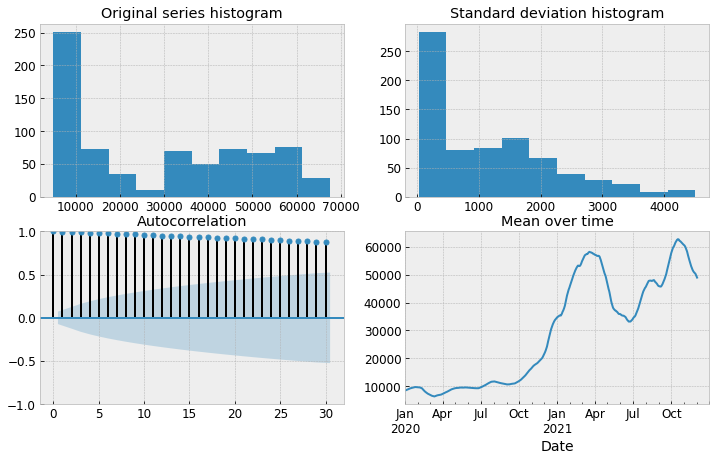

In [ ]:
fig = plt.figure(figsize=(12, 7))
layout = (2, 2)
hist_ax = plt.subplot2grid(layout, (0, 0))
ac_ax = plt.subplot2grid(layout, (1, 0))
hist_std_ax = plt.subplot2grid(layout, (0, 1))
mean_ax = plt.subplot2grid(layout, (1, 1))

df.Close.hist(ax=hist_ax)
hist_ax.set_title("Original series histogram")

plot_acf(series, lags=30, ax=ac_ax)
ac_ax.set_title("Autocorrelation")

mm = df.Close.rolling(7).std()
mm.hist(ax=hist_std_ax)
hist_std_ax.set_title("Standard deviation histogram")

mm = df.Close.rolling(30).mean()
mm.plot(ax=mean_ax)
mean_ax.set_title("Mean over time")

We can see our series do not follow a Gaussian distribution from the histogram and neither the standard deviation, and the std does have the mean more tailed.

The mean over time also shows something similar with a not constant value and high peaks in the last year

### Stationarity

Stationarity is an important characteristic of time series. A time series is stationarity if it has constant mean and variance over time. Most models work only with stationary data as this makes it easier to model. Not all time series are stationary but we can transform them into stationary series in different ways.

We notice the Crypto prices are not a stationary, since we see a growing trend, or its volatility might increase over time (meaning that variance is changing).

#### **Check for sationarity**

##### **Autocorrelation and Partial autocorrelation plots**

Autocorelation plots show how correlated are values at time t with the next values in time t+1,t+2,..t+n. If the data would be non-stationary the autocorrelation values will be highly correlated with distant points in time showing possible seasonalities or trends.

Stationary series autocorrelation values will quickly decrease over time t. This shows us that no information is carried over time and then the series should be constant over time.

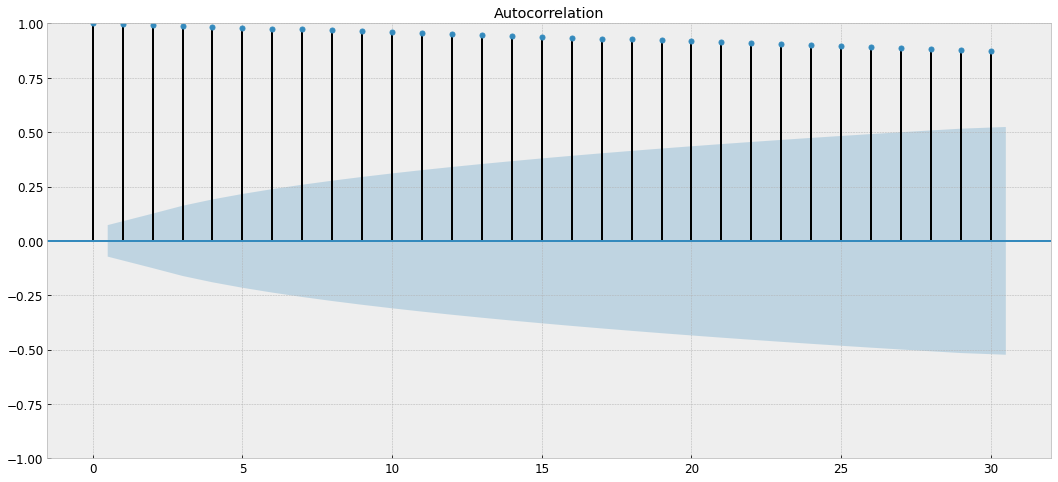

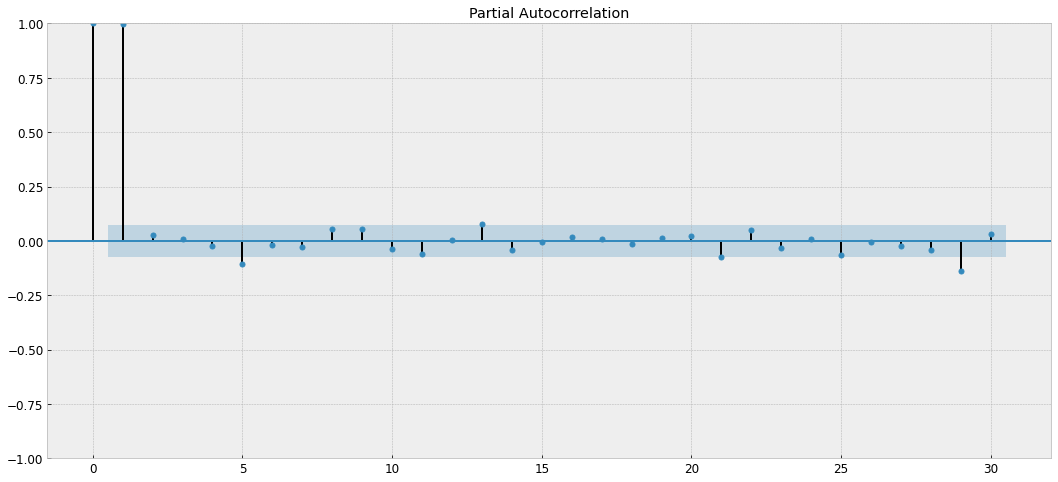

In [ ]:
plot_acf(series, lags=30)
plot_pacf(series, lags=30)
plt.show()

We saw that our time series values are not correlated with distant points in time, this is good and shows us our series should be stationary. We can also check with certain tests

##### **Rolling means and standard deviation of our series**

We were talking about how our mean and standard deviation should be constant over time in order to have a stationary time series

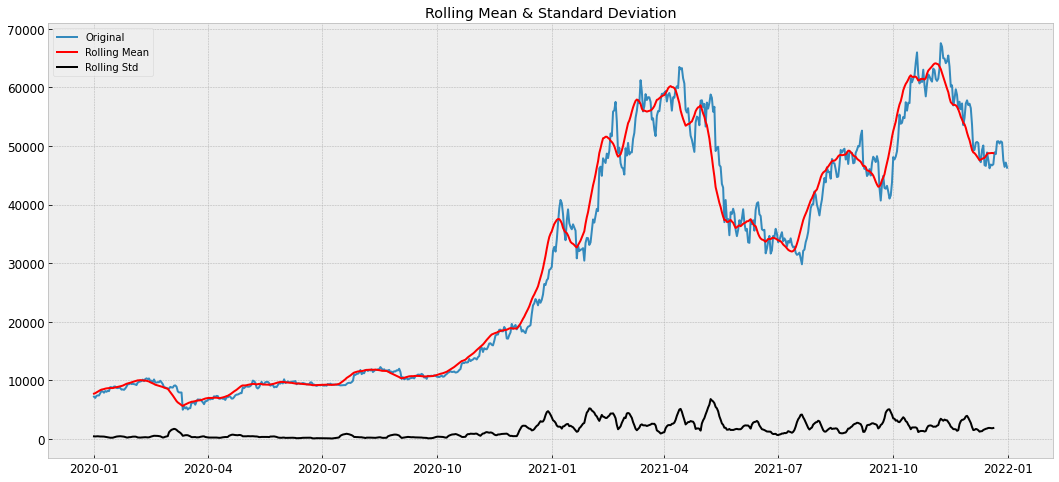

In [ ]:
# Determing rolling statistics
rolmean = df.Close.rolling(window=12).mean()
rolstd = df.Close.rolling(window=12).std()

# Plot rolling statistics:
orig = plt.plot(df.Close, label='Original')
mean = plt.plot(rolmean, color='red', label='Rolling Mean')
std = plt.plot(rolstd, color='black', label='Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False)

We can see how our mean and standar deviation have a constant behaviour over the years, even if they change over the year this behaviour is then repeated next year. This proves us again a stationary series

##### **Augmented Dickey-Fuller test**

The Augmented Dickey-Fuller test is a type of statistical test called a unit root test. The intuition behind a unit root test is that it determines how strongly a time series is defined by a trend. There are a number of unit root tests and the Augmented Dickey-Fuller may be one of the more widely used. It uses an autoregressive model and optimizes an information criterion across multiple different lag values.

The null hypothesis of the test is that the time series can be represented by a unit root, that it is not stationary (has some time-dependent structure). The alternate hypothesis (rejecting the null hypothesis) is that the time series is stationary.

Null Hypothesis (H0): If failed to be rejected, it suggests the time series has a unit root, meaning it is non-stationary. It has some time dependent structure. Alternate Hypothesis (H1): The null hypothesis is rejected; it suggests the time series does not have a unit root, meaning it is stationary. It does not have time-dependent structure. We interpret this result using the p-value from the test. A p-value below a threshold (such as 5% or 1%) suggests we reject the null hypothesis (stationary), otherwise a p-value above the threshold suggests we fail to reject the null hypothesis (non-stationary).

p-value > 0.05: Fail to reject the null hypothesis (H0), the data has a unit root and is non-stationary. p-value <= 0.05: Reject the null hypothesis (H0), the data does not have a unit root and is stationary. Below is an example of calculating the Augmented Dickey-Fuller test on the Daily Female Births dataset. The statsmodels library provides the adfuller() function that implements the test.

In [ ]:
X = df.Close.values
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -0.812165
p-value: 0.815523
Critical Values:
	1%: -3.439
	5%: -2.866
	10%: -2.569


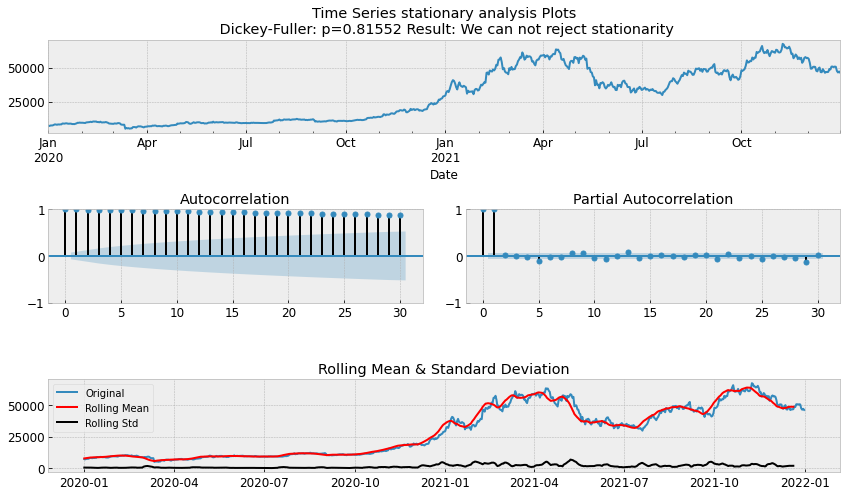

In [ ]:
def tsplot(y, lags=None, figsize=(12, 7), syle='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)

    with plt.style.context(style='bmh'):
        fig = plt.figure(figsize=(12, 7))
        layout = (3, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        mean_std_ax = plt.subplot2grid(layout, (2, 0), colspan=2)
        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        hypothesis_result = "We reject stationarity" if p_value <= 0.05 else "We can not reject stationarity"
        ts_ax.set_title(
            'Time Series stationary analysis Plots\n Dickey-Fuller: p={0:.5f} Result: {1}'.format(p_value, hypothesis_result))
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()

        rolmean = df.Close.rolling(window=12).mean()
        rolstd = df.Close.rolling(window=12).std()

        # Plot rolling statistics:
        orig = plt.plot(df.Close, label='Original')
        mean = plt.plot(rolmean, color='red', label='Rolling Mean')
        std = plt.plot(rolstd, color='black', label='Rolling Std')
        plt.legend(loc='best')
        plt.title('Rolling Mean & Standard Deviation')


tsplot(df.Close, lags=30)

With a p value of ~1 and high correlation values over time distant samples (showing a clear seasonality shape) we need to apply some methods to make the series stationary.

Coming back to the stationary definition, what makes our current series non stationary?

**Trend** - The mean for our series is not constant, it increases over time and

**Seasonality** - The values of our series vary over time with an specific pattern that repeats over time, this is called seasonalities (spike of people flying during Christmas)

We now present some methods to remove or smoth this trend and seasonality components

#### **Making Time Series Stationary**

##### **Difference transform**

Applying a difference transform to a time series could help remove the series dependence on time.

This transform is done by substracting the previous obesvation to the current one.

**difference(t) = observation(t) - observation(t-1)**

Taking the difference between consecutive observations would be a lag-1 difference, we can tweek this lag value to fit our series.

We can also apply differencing transforms consecutively in the same series if the temporal effect hasnt been removed yet. This is called multiple order difference transform

In [ ]:
def difference(dataset, interval=1, order=1):
    for u in range(order):
        diff = list()
        for i in range(interval, len(dataset)):
            value = dataset[i] - dataset[i - interval]
            diff.append(value)
        dataset = diff
    return diff

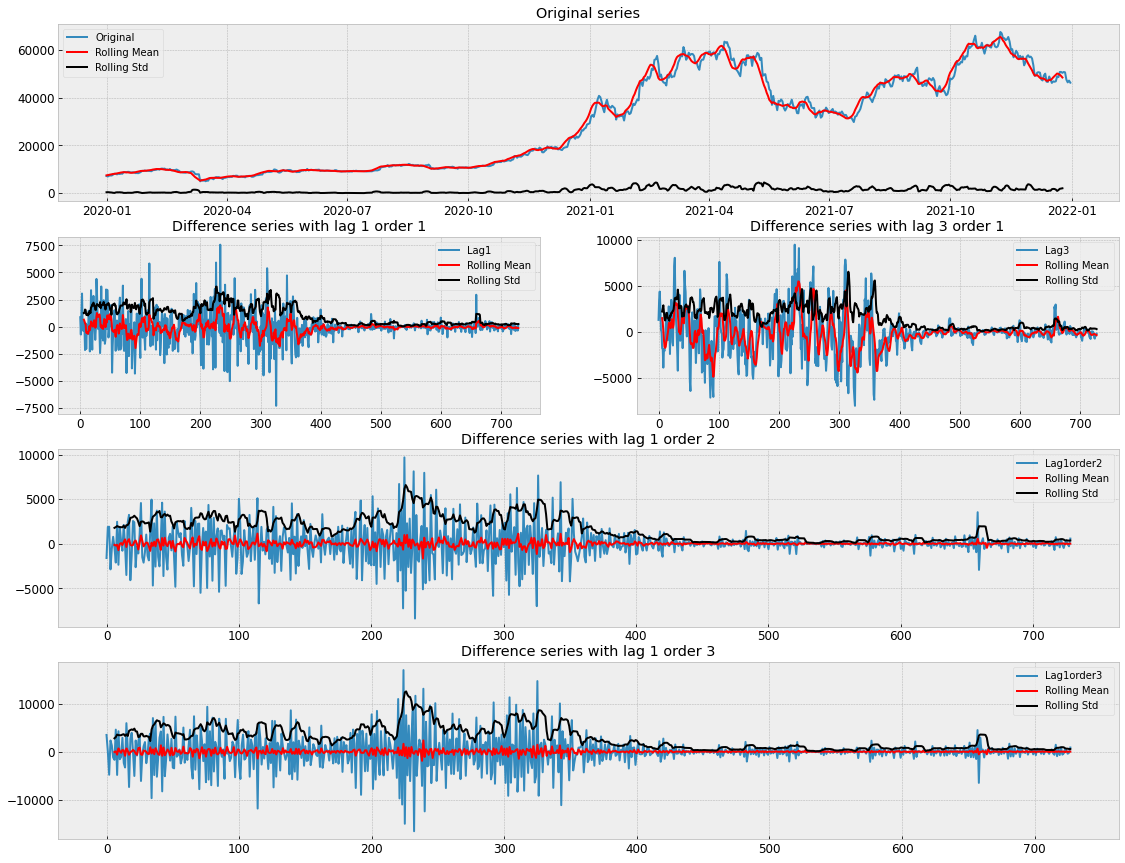

In [ ]:
lag1series = pd.Series(difference(df.Close, interval=1, order=1))
lag3series = pd.Series(difference(df.Close, interval=3, order=1))
lag1order2series = pd.Series(difference(
    df.Close, interval=1, order=2))
lag1order3series = pd.Series(difference(
    df.Close, interval=1, order=3))

fig = plt.figure(figsize=(19, 15))
layout = (4, 2)
original = plt.subplot2grid(layout, (0, 0), colspan=2)
lag1 = plt.subplot2grid(layout, (1, 0))
lag3 = plt.subplot2grid(layout, (1, 1))
lag1order2 = plt.subplot2grid(layout, (2, 0), colspan=2)
lag1order3 = plt.subplot2grid(layout, (3, 0), colspan=2)

original.set_title('Original series')
original.plot(df.Close, label='Original')
original.plot(df.Close.rolling(
    7).mean(), color='red', label='Rolling Mean')
original.plot(df.Close.rolling(7).std(),
              color='black', label='Rolling Std')
original.legend(loc='best')

lag1.set_title('Difference series with lag 1 order 1')
lag1.plot(lag1series, label="Lag1")
lag1.plot(lag1series.rolling(7).mean(), color='red', label='Rolling Mean')
lag1.plot(lag1series.rolling(7).std(), color='black', label='Rolling Std')
lag1.legend(loc='best')

lag3.set_title('Difference series with lag 3 order 1')
lag3.plot(lag3series, label="Lag3")
lag3.plot(lag3series.rolling(7).mean(), color='red', label='Rolling Mean')
lag3.plot(lag3series.rolling(7).std(), color='black', label='Rolling Std')
lag3.legend(loc='best')

lag1order2.set_title('Difference series with lag 1 order 2')
lag1order2.plot(lag1order2series, label="Lag1order2")
lag1order2.plot(lag1order2series.rolling(7).mean(),
                color='red', label='Rolling Mean')
lag1order2.plot(lag1order2series.rolling(7).std(),
                color='black', label='Rolling Std')
lag1order2.legend(loc='best')

lag1order3.set_title('Difference series with lag 1 order 3')
lag1order3.plot(lag1order3series, label="Lag1order3")
lag1order3.plot(lag1order3series.rolling(7).mean(),
                color='red', label='Rolling Mean')
lag1order3.plot(lag1order3series.rolling(7).std(),
                color='black', label='Rolling Std')
lag1order3.legend(loc='best')

We can see how 1 order differencing doesnt really remove stationary but once we go with a order 2 and 3 difference it looks closer to a stationary series

##### **Log scale transformation**

Applying a log scale transform to a time series could also help remove the series dependence on time.

This transform is done by substracting the previous obesvation to the current one.

**LogScaleTransform(t)= Log(t)**

Text(0.5, 1.0, 'Log scale transformation into original series')

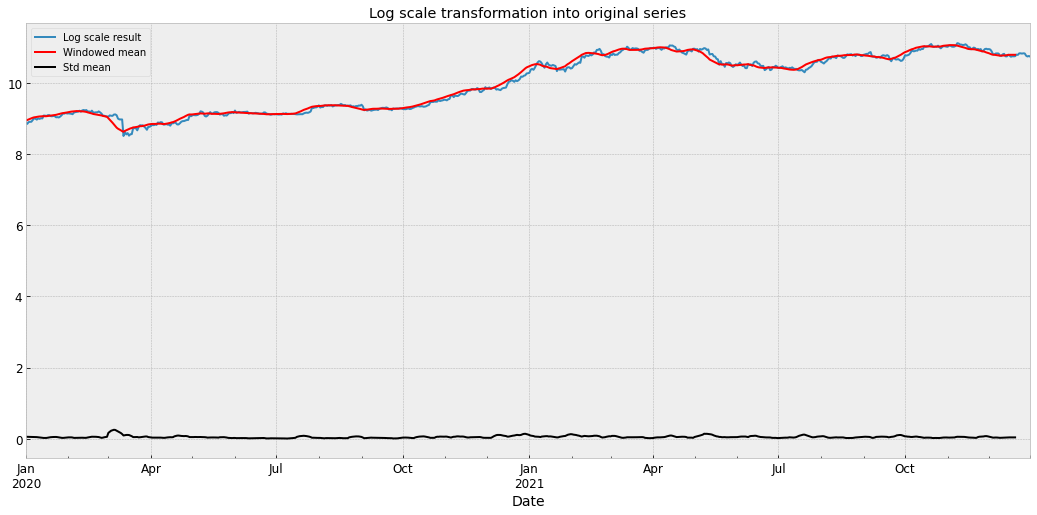

In [ ]:
ts_log = np.log(df.Close)
ts_log.plot(label='Log scale result')
ts_log.rolling(window=12).mean().plot(color='red', label='Windowed mean')
ts_log.rolling(window=12).std().plot(color='black', label='Std mean')
plt.legend()
plt.title('Log scale transformation into original series')

##### **Smoothing**

We have seen the moving mean as a measure to check stationarity, we can also apply this windows to our series to remove seasonality.

With smotthing we will take rolling averages over periods of time.

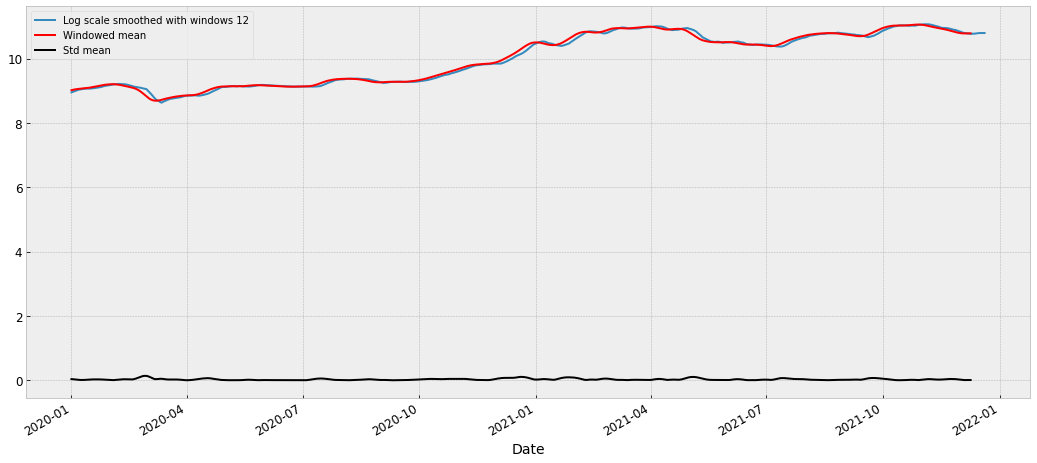

In [ ]:
avg = pd.Series(ts_log).rolling(12).mean()
plt.plot(avg, label='Log scale smoothed with windows 12')
avg.rolling(window=12).mean().plot(color='red', label='Windowed mean')
avg.rolling(window=12).std().plot(color='black', label='Std mean')
plt.legend()

We can combine it with our previous log scale and apply differencing

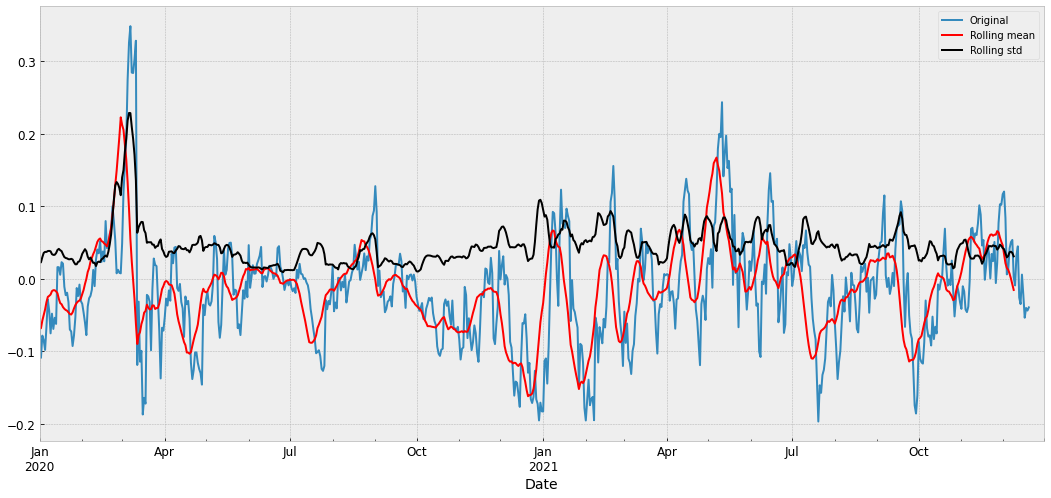

In [ ]:
ts_log_moving_avg_diff = ts_log - avg

ts_log_moving_avg_diff.plot(label='Original')
ts_log_moving_avg_diff.rolling(12).mean().plot(
    color='red', label="Rolling mean")
ts_log_moving_avg_diff.rolling(12).std().plot(
    color='black', label="Rolling std")
plt.legend(loc='best')

## Methods for time series forecasting

There are many methods that we can use for time series forecasting and there is not a clear winner. Model selection should always depend on how we look at the data and what are we trying to achieve. Some models may be more robust against outliers but perform worse than the more sensible and could still be the best choice depending on the use case.

When looking at our data the main split is wether we have extra regressors (features) to our time series or just the series. Based on this we can start exploring different methods for forecasting and their performance in different metrics.

In this section we will show models for both cases, time series with and without extra regressors.

### **Prepare data before modeling**

In [ ]:
# We split our dataset to be able to evaluate our models

resultsDict = {}
predictionsDict = {}

split_date = '2021-05-01'
df_training = df.loc[df.index <= split_date]
df_test = df.loc[df.index > split_date]
print(f"{len(df_training)} days of training data \n {len(df_test)} days of testing data ")

487 days of training data 
 244 days of testing data 


It is also very important to include some naive forecast as the series mean or previous value to make sure our models perform better than the simplest of the simplest. We dont want to introduce any complexity if it does not provides any performance gain.

In [ ]:
# Also add the naive mean average value
mean = df_training.Close.mean()
mean = np.array([mean for u in range(len(df_test))])
resultsDict['Naive mean'] = evaluate(df_test.Close, mean)
predictionsDict['Naive mean'] = mean

### **Univariate-time-series-forecasting**

In this section we will focus on time series forecasting methods capable of only looking at the target variable. This means no other regressors (more variables) can be added into the model.

#### Simple Exponential Smoothing (SES)

The Simple Exponential Smoothing (SES) method models the next time step as an exponentially weighted linear function of observations at prior time steps. This method expects our time series to be non stationary in order to perform adecuately (no trend or seasonality)

In [ ]:
# Walk throught the test data, training and predicting 1 day ahead for all the test data
index = len(df_training)
yhat = list()
for t in tqdm(range(len(df_test.Close))):
    temp_train = df[:len(df_training)+t]
    model = SimpleExpSmoothing(temp_train.Close)
    model_fit = model.fit()
    predictions = model_fit.predict(start=len(temp_train), end=len(temp_train))
    yhat = yhat + [predictions]

yhat = pd.concat(yhat)
resultsDict['SES'] = evaluate(df_test.Close, yhat.values)
predictionsDict['SES'] = yhat.values

100%|██████████| 244/244 [00:04<00:00, 53.54it/s]


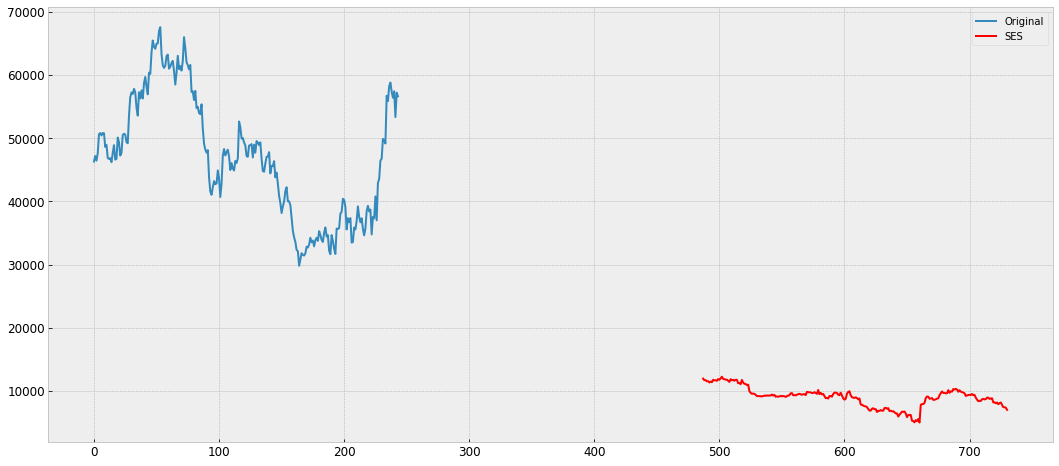

In [ ]:
plt.plot(df_test.Close.values, label='Original')
plt.plot(yhat, color='red', label='SES')
plt.legend()

#### Holt Winter’s Exponential Smoothing (Triple Exponential Smoothing)

In [ ]:
# Walk throught the test data, training and predicting 1 day ahead for all the test data
index = len(df_training)
yhat = list()
for t in tqdm(range(len(df_test.Close))):
    temp_train = df[:len(df_training)+t]
    model = ExponentialSmoothing(temp_train.Close)
    model_fit = model.fit()
    predictions = model_fit.predict(start=len(temp_train), end=len(temp_train))
    yhat = yhat + [predictions]

yhat = pd.concat(yhat)
resultsDict['HWES'] = evaluate(df_test.Close, yhat.values)
predictionsDict['HWES'] = yhat.values

100%|██████████| 244/244 [00:04<00:00, 51.97it/s]


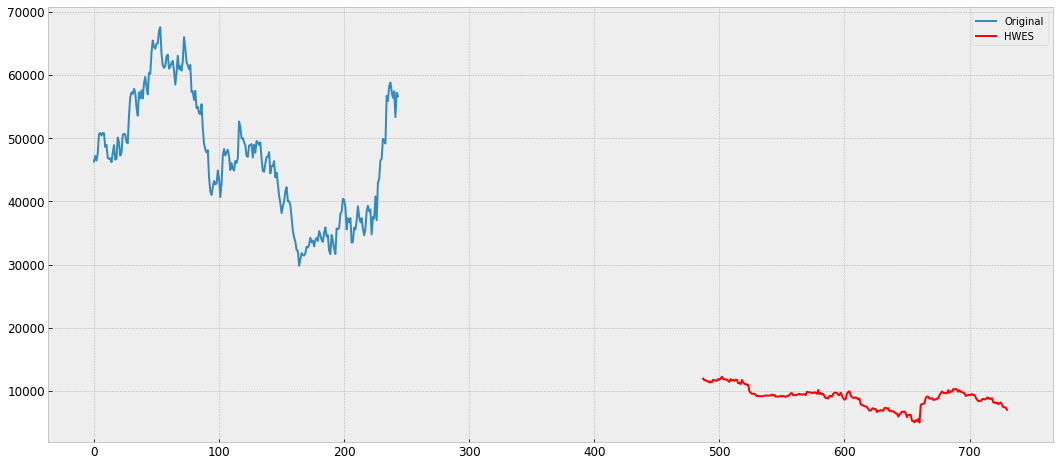

In [ ]:
plt.plot(df_test.Close.values, label='Original')
plt.plot(yhat, color='red', label='HWES')
plt.legend()

#### Autoregressive integrated moving average (ARIMA)

In an ARIMA model there are 3 parameters that are used to help model the major aspects of a times series: seasonality, trend, and noise. These parameters are labeled p,d,and q.

*   **Number of AR (Auto-Regressive) terms (p):** p is the parameter associated with the auto-regressive aspect of the model, which incorporates past values i.e lags of dependent variable. For instance if p is 5, the predictors for x(t) will be x(t-1)….x(t-5).
*   **Number of Differences (d):** d is the parameter associated with the integrated part of the model, which effects the amount of differencing to apply to a time series.
*   **Number of MA (Moving Average) terms (q):** q is size of the moving average part window of the model i.e. lagged forecast errors in prediction equation. For instance if q is 5, the predictors for x(t) will be e(t-1)….e(t-5) where e(i) is the difference between the moving average at ith instant and actual value.

**Tuning ARIMA parameters**

Non stationarity series will require level of differencing (d) >0 in ARIMA Select the lag values for the Autoregression (AR) and Moving Average (MA) parameters, p and q respectively, using PACF, ACF plots AUTOARIMA

Note: A problem with ARIMA is that it does not support seasonal data. That is a time series with a repeating cycle. ARIMA expects data that is either not seasonal or has the seasonal component removed, e.g. seasonally adjusted via methods such as seasonal differencing.

In [ ]:
# Walk throught the test data, training and predicting 1 day ahead for all the test data
index = len(df_training)
yhat = list()
for t in tqdm(range(len(df_test.Close))):
    temp_train = df[:len(df_training)+t]
    model = ARIMA(temp_train.Close, order=(1, 0, 0))
    model_fit = model.fit()
    predictions = model_fit.predict(
        start=len(temp_train), end=len(temp_train), dynamic=False)
    yhat = yhat + [predictions]

yhat = pd.concat(yhat)
resultsDict['ARIMA'] = evaluate(df_test.Close, yhat.values)
predictionsDict['ARIMA'] = yhat.values

100%|██████████| 244/244 [00:26<00:00,  9.05it/s]


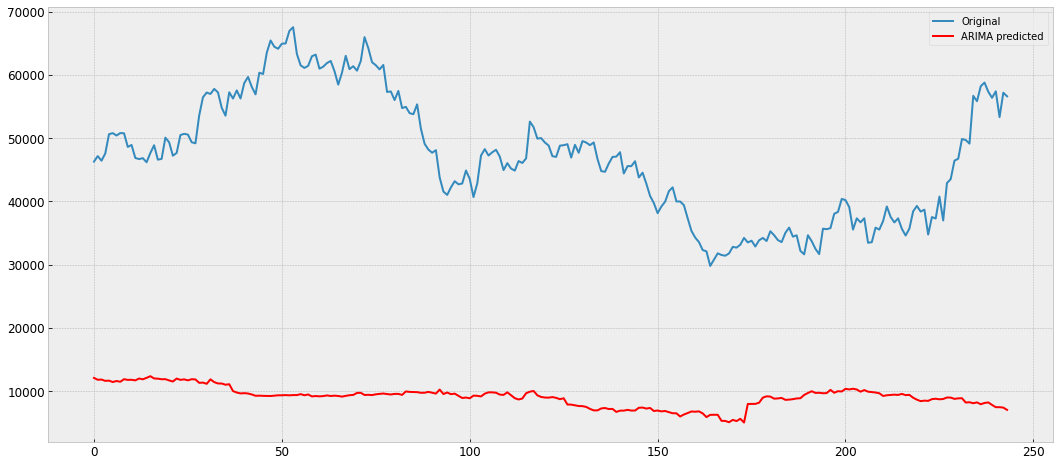

In [ ]:
plt.plot(df_test.Close.values, label='Original')
plt.plot(yhat.values, color='red', label='ARIMA predicted')
plt.legend()

##### **Auto ARIMA**

In [ ]:
# building the model

autoModel = pm.auto_arima(df_training.Close, trace=True,
                          error_action='ignore', suppress_warnings=True, seasonal=False)
autoModel.fit(df_training.Close)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=8160.254, Time=1.95 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=8164.315, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=8166.314, Time=0.13 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=8166.317, Time=1.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=8166.891, Time=0.04 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=8162.907, Time=1.13 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=8161.838, Time=0.63 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=8163.263, Time=1.22 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=8147.977, Time=2.28 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=8163.656, Time=0.95 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=8163.140, Time=4.05 sec
 ARIMA(2,1,4)(0,0,0)[0] intercept   : AIC=inf, Time=2.98 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=8167.729, Time=0.80 sec
 ARIMA(3,1,4)(0,0,0)[0] intercept   : AIC=8167.303, Time=1.57 sec
 ARIMA(2,1,3)(0,0,0)[0]             : 

ARIMA(order=(2, 1, 3), scoring_args={}, suppress_warnings=True)

In [ ]:
order = autoModel.order
yhat = list()
for t in tqdm(range(len(df_test.Close))):
    temp_train = df[:len(df_training)+t]
    model = ARIMA(temp_train.Close, order=order)
    model_fit = model.fit()
    predictions = model_fit.predict(start=len(temp_train), end=len(temp_train), dynamic=False)
    yhat = yhat + [predictions]

yhat = pd.concat(yhat)
resultsDict['AutoARIMA {0}'.format(order)] = evaluate(df_test.Close, yhat)
predictionsDict['AutoARIMA {0}'.format(order)] = yhat.values

100%|██████████| 244/244 [02:09<00:00,  1.89it/s]


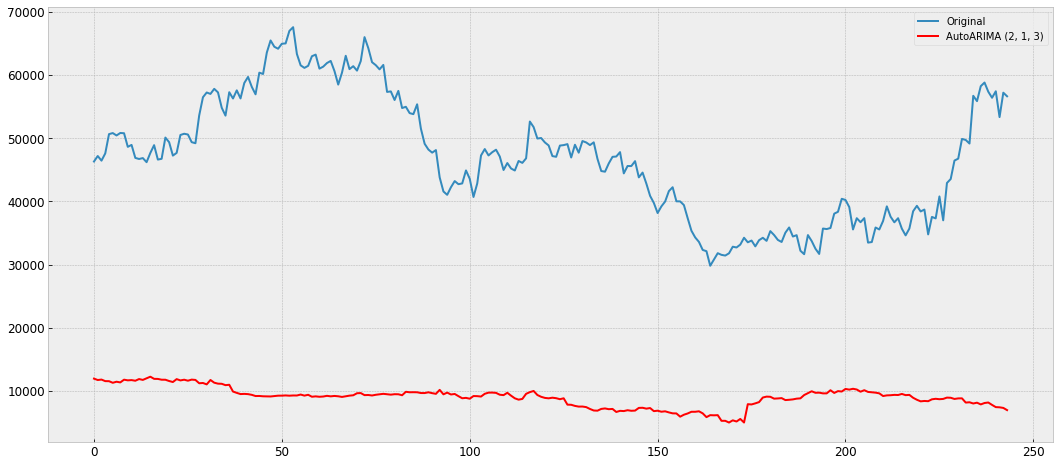

In [ ]:
plt.plot(df_test.Close.values, label='Original')
plt.plot(yhat.values, color='red', label='AutoARIMA {0}'.format(order))
plt.legend()

#### Seasonal Autoregressive Integrated Moving-Average (SARIMA)

Seasonal Autoregressive Integrated Moving Average, SARIMA or Seasonal ARIMA, is an extension of ARIMA that explicitly supports univariate time series data with a seasonal component.

It adds three new hyperparameters to specify the autoregression (AR), differencing (I) and moving average (MA) for the seasonal component of the series, as well as an additional parameter for the period of the seasonality.

**Trend Elements:**

There are three trend elements that require configuration. They are the same as the ARIMA model, specifically:


*   p: Trend autoregression order.
*   d: Trend difference order.
*   q: Trend moving average order.

**Seasonal Elements:**

There are four seasonal elements that are not part of ARIMA that must be configured; they are:


*   P: Seasonal autoregressive order.
*   D: Seasonal difference order.
*   Q: Seasonal moving average order.
*   m: The number of time steps for a single seasonal period. For example, an S of 12 for monthly data suggests a yearly seasonal cycle.


**SARIMA notation: SARIMA(p,d,q)(P,D,Q,m)**

In [ ]:
index = len(df_training)
yhat = list()
for t in tqdm(range(len(df_test.Close))):
    temp_train = df[:len(df_training)+t]
    model = SARIMAX(temp_train.Close, order=(
        1, 0, 0), seasonal_order=(0, 0, 0, 3))
    model_fit = model.fit(disp=False)
    predictions = model_fit.predict(
        start=len(temp_train), end=len(temp_train), dynamic=False)
    yhat = yhat + [predictions]

yhat = pd.concat(yhat)
resultsDict['SARIMAX'] = evaluate(df_test.Close, yhat.values)
predictionsDict['SARIMAX'] = yhat.values

100%|██████████| 244/244 [00:08<00:00, 27.79it/s]


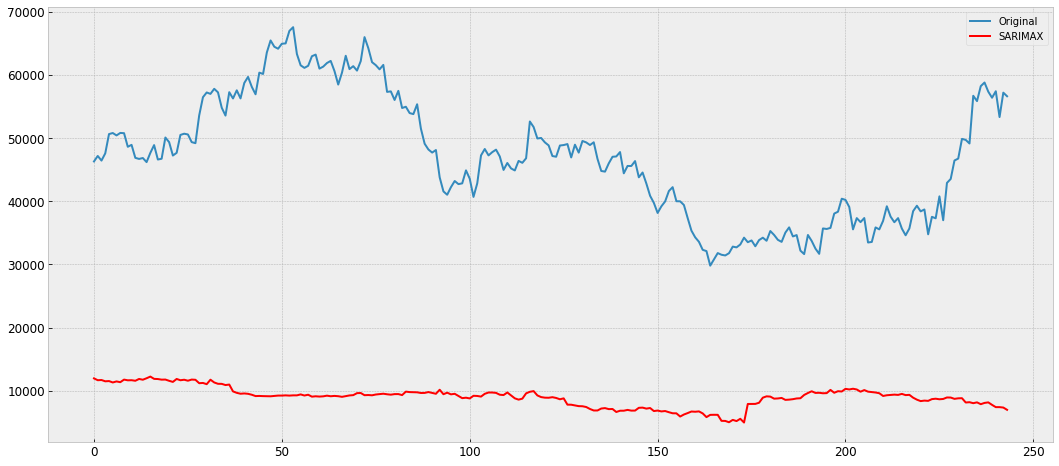

In [ ]:
plt.plot(df_test.Close.values, label='Original')
plt.plot(yhat.values, color='red', label='SARIMAX')
plt.legend()

#### Auto - SARIMA

In [ ]:
# building the model
autoModel = pm.auto_arima(df_training.Close, trace=True, error_action='ignore',
                          suppress_warnings=True, seasonal=True, m=6, stepwise=True)
autoModel.fit(df_training.Close)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[6] intercept   : AIC=8152.799, Time=2.60 sec
 ARIMA(0,1,0)(0,0,0)[6] intercept   : AIC=8164.315, Time=0.03 sec
 ARIMA(1,1,0)(1,0,0)[6] intercept   : AIC=8159.510, Time=0.13 sec
 ARIMA(0,1,1)(0,0,1)[6] intercept   : AIC=8158.927, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[6]             : AIC=8166.891, Time=0.02 sec
 ARIMA(2,1,2)(0,0,1)[6] intercept   : AIC=8154.227, Time=1.93 sec
 ARIMA(2,1,2)(1,0,0)[6] intercept   : AIC=8163.010, Time=0.61 sec
 ARIMA(2,1,2)(2,0,1)[6] intercept   : AIC=8154.065, Time=4.15 sec
 ARIMA(2,1,2)(1,0,2)[6] intercept   : AIC=8154.182, Time=3.14 sec
 ARIMA(2,1,2)(0,0,0)[6] intercept   : AIC=8160.254, Time=0.88 sec
 ARIMA(2,1,2)(0,0,2)[6] intercept   : AIC=8156.154, Time=2.24 sec
 ARIMA(2,1,2)(2,0,0)[6] intercept   : AIC=8156.441, Time=3.53 sec
 ARIMA(2,1,2)(2,0,2)[6] intercept   : AIC=inf, Time=4.03 sec
 ARIMA(1,1,2)(1,0,1)[6] intercept   : AIC=8155.124, Time=0.96 sec
 ARIMA(2,1,1)(1,0,1)[6] intercept   : 

ARIMA(order=(2, 1, 2), scoring_args={}, seasonal_order=(1, 0, 1, 6),
      suppress_warnings=True)

In [ ]:
order = autoModel.order
seasonalOrder = autoModel.seasonal_order
yhat = list()
for t in tqdm(range(len(df_test.Close))):
    temp_train = df[:len(df_training)+t]
    model = SARIMAX(temp_train.Close, order=order,
                    seasonal_order=seasonalOrder)
    model_fit = model.fit(disp=False)
    predictions = model_fit.predict(
        start=len(temp_train), end=len(temp_train), dynamic=False)
    yhat = yhat + [predictions]

yhat = pd.concat(yhat)
resultsDict['AutoSARIMAX {0},{1}'.format(order, seasonalOrder)] = evaluate(
    df_test.Close, yhat.values)
predictionsDict['AutoSARIMAX {0},{1}'.format(
    order, seasonalOrder)] = yhat.values

100%|██████████| 244/244 [04:54<00:00,  1.21s/it]


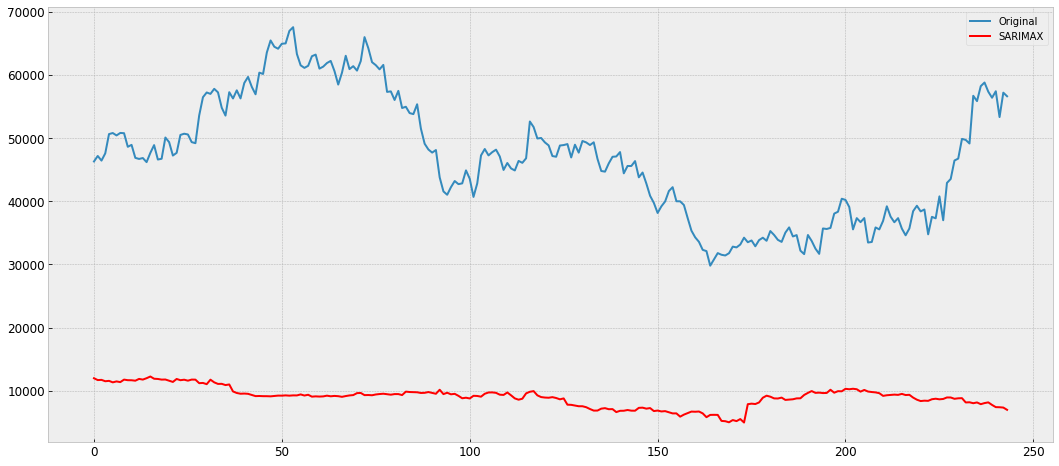

In [ ]:
plt.plot(df_test.Close.values, label='Original')
plt.plot(yhat.values, color='red', label='SARIMAX')
plt.legend()

#### Prophet

Prophet is a model released by facebook. Is essentially a curve fitting approach, very similar in spirit to how BSTS models trend and seasonality, except that it uses generalized additive models instead of a state-space representation to describe each component.

In [ ]:
# Prophet needs some specifics data stuff, coment it here
prophet_training = df_training.rename(
    columns={'Close': 'y'})  # old method
prophet_training['ds'] = prophet_training.index
prophet_training.index = pd.RangeIndex(len(prophet_training.index))

prophet_test = df_test.rename(columns={'Close': 'y'})  # old method
prophet_test['ds'] = prophet_test.index
prophet_test.index = pd.RangeIndex(len(prophet_test.index))

In [ ]:
prophet = Prophet(
).add_seasonality(
    name='monthly',
    period=30.5,
    fourier_order=55
).add_seasonality(
    name='daily',
    period=1,
    fourier_order=15
).add_seasonality(
    name='weekly',
    period=7,
    fourier_order=25
).add_seasonality(
    name='yearly',
    period=365.25,
    fourier_order=20
).add_seasonality(
    name='quarterly',
    period=365.25/4,
    fourier_order=55
)

In [ ]:
prophet.fit(prophet_training)
yhat = prophet.predict(prophet_test)
resultsDict['Prophet univariate'] = evaluate(
    df_test.Close, yhat.yhat.values)
predictionsDict['Prophet univariate'] = yhat.yhat.values

INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Found custom seasonality named 'daily', disabling built-in 'daily' seasonality.


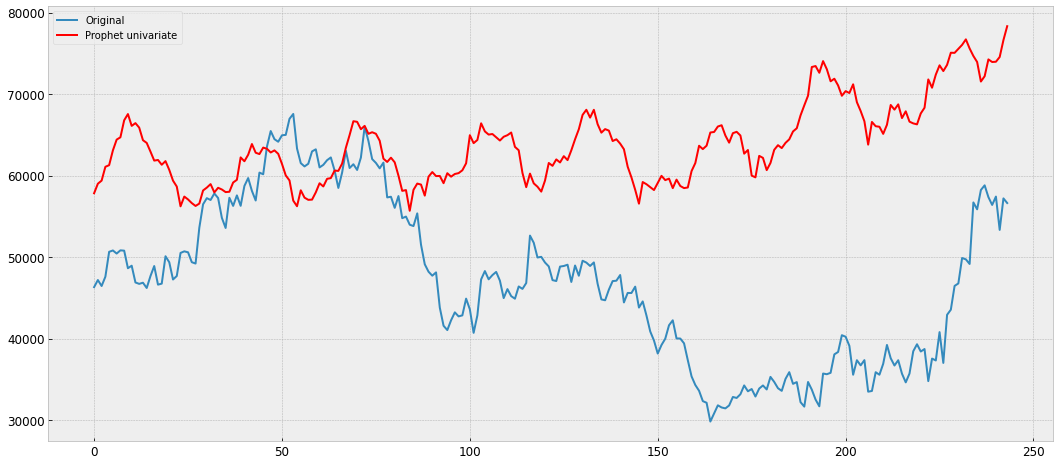

In [ ]:
plt.plot(df_test.Close.values, label='Original')
plt.plot(yhat.yhat, color='red', label='Prophet univariate')
plt.legend()

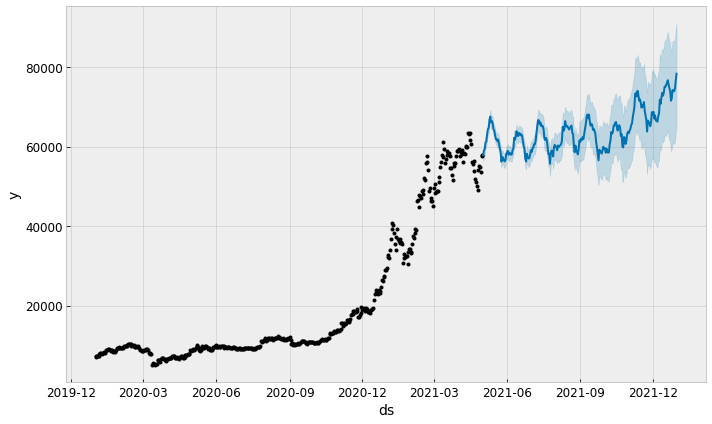

In [ ]:
fig1 = prophet.plot(yhat)

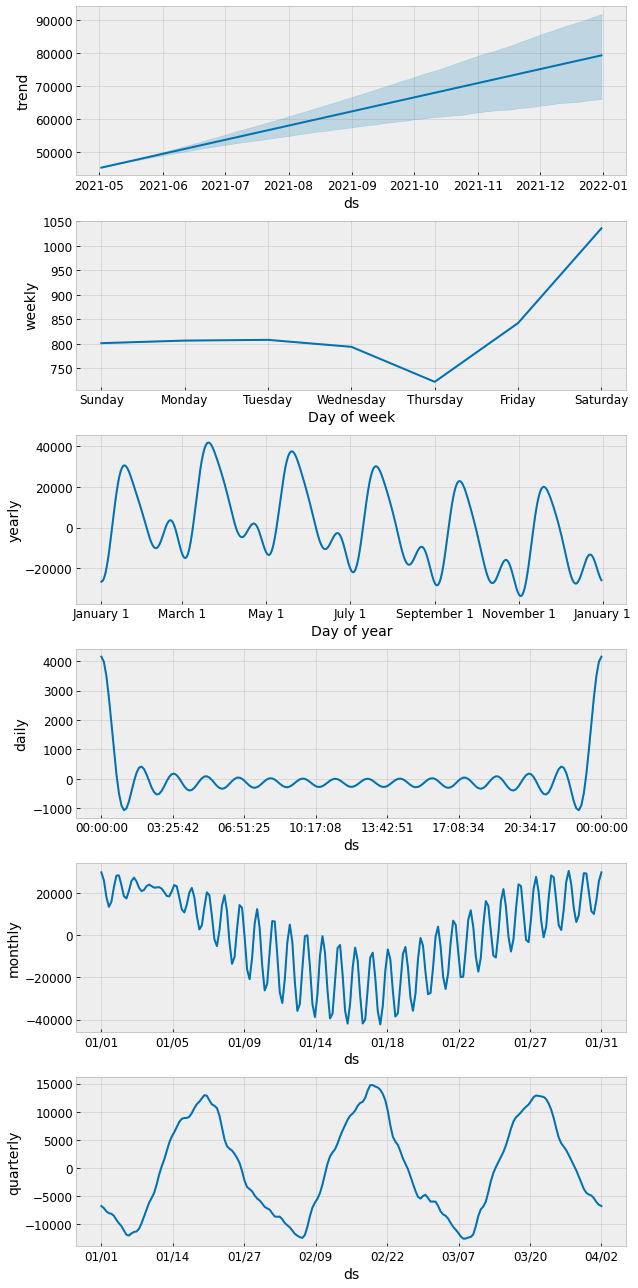

In [ ]:
fig2 = prophet.plot_components(yhat)

### **Multivariate time series forecasting**

In [ ]:
# ADD time features to our model
def create_time_features(df, target=None):
    """
    Creates time series features from datetime index
    """
    df['date'] = df.index
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['sin_day'] = np.sin(df['dayofyear'])
    df['cos_day'] = np.cos(df['dayofyear'])
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.weekofyear
    X = df.drop(['date'], axis=1)
    if target:
        y = df[target]
        X = X.drop([target], axis=1)
        return X, y

    return X

In [ ]:
X_train_df, y_train = create_time_features(
    df_training, target='Close')
X_test_df, y_test = create_time_features(df_test, target='Close')
scaler = StandardScaler()
scaler.fit(X_train_df)  # No cheating, never scale on the training+test!
X_train = scaler.transform(X_train_df)
X_test = scaler.transform(X_test_df)

X_train_df = pd.DataFrame(X_train, columns=X_train_df.columns)
X_test_df = pd.DataFrame(X_test, columns=X_test_df.columns)

#### Linear models

##### Bayesian regression

In [ ]:
reg = linear_model.BayesianRidge()
reg.fit(X_train, y_train)
yhat = reg.predict(X_test)
resultsDict['BayesianRidge'] = evaluate(df_test.Close, yhat)
predictionsDict['BayesianRidge'] = yhat

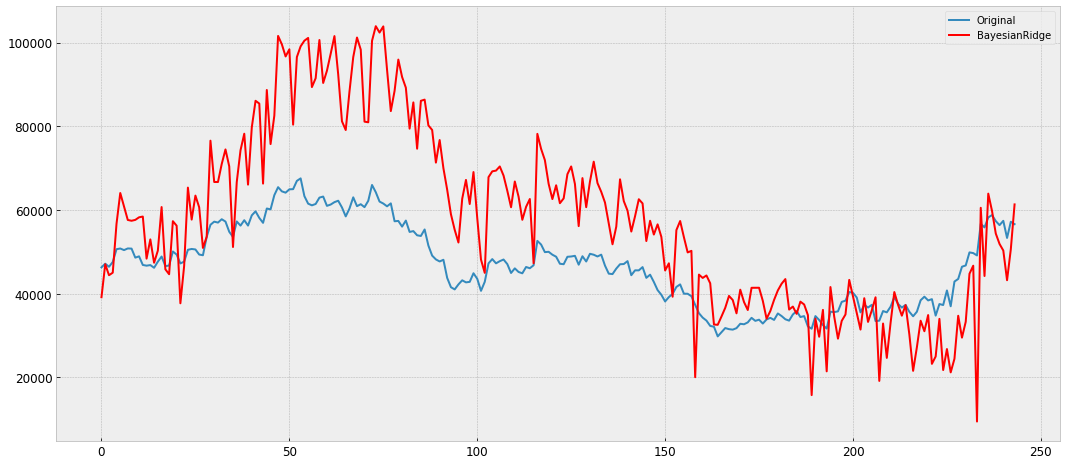

In [ ]:
plt.plot(df_test.Close.values, label='Original')
plt.plot(yhat, color='red', label='BayesianRidge')
plt.legend()

##### Lasso

In [ ]:
reg = linear_model.Lasso(alpha=0.1)
reg.fit(X_train, y_train)
yhat = reg.predict(X_test)
resultsDict['Lasso'] = evaluate(df_test.Close, yhat)
predictionsDict['Lasso'] = yhat

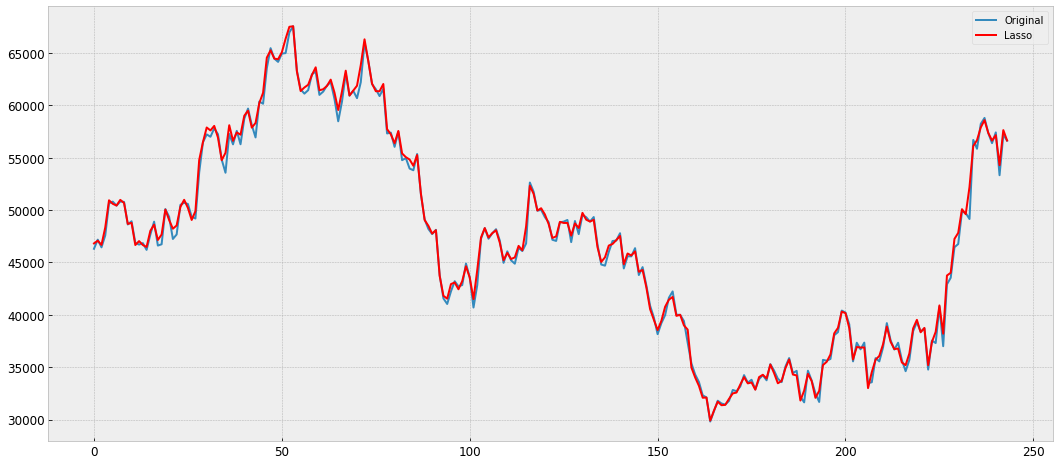

In [ ]:
plt.plot(df_test.Close.values, label='Original')
plt.plot(yhat, color='red', label='Lasso')
plt.legend()

#### Tree models

##### Randomforest

In [ ]:
reg = RandomForestRegressor(max_depth=2, random_state=0)
reg.fit(X_train, y_train)
yhat = reg.predict(X_test)
resultsDict['Randomforest'] = evaluate(df_test.Close, yhat)
predictionsDict['Randomforest'] = yhat

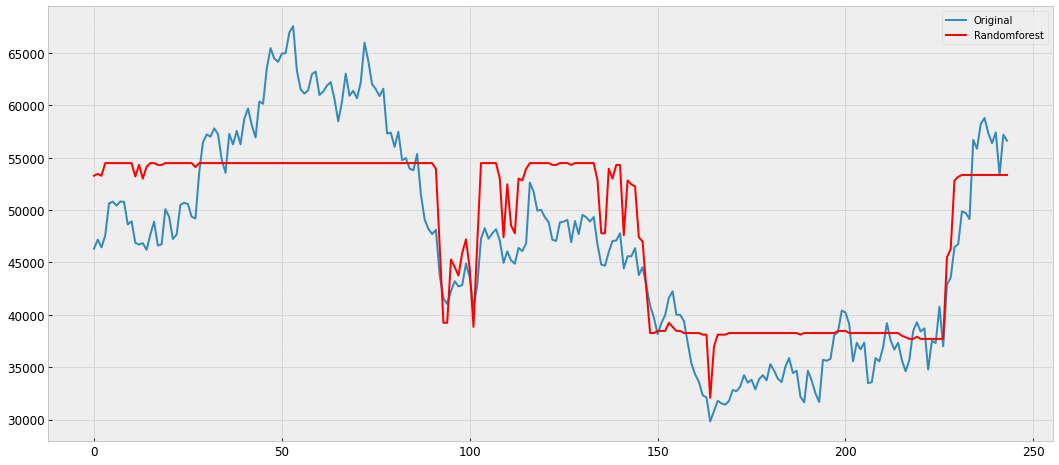

In [ ]:
plt.plot(df_test.Close.values, label='Original')
plt.plot(yhat, color='red', label='Randomforest')
plt.legend()

##### XGBoost

In [ ]:
reg = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=1000)
reg.fit(X_train, y_train,
        verbose=False)  # Change verbose to True if you want to see it train
yhat = reg.predict(X_test)
resultsDict['XGBoost'] = evaluate(df_test.Close, yhat)
predictionsDict['XGBoost'] = yhat

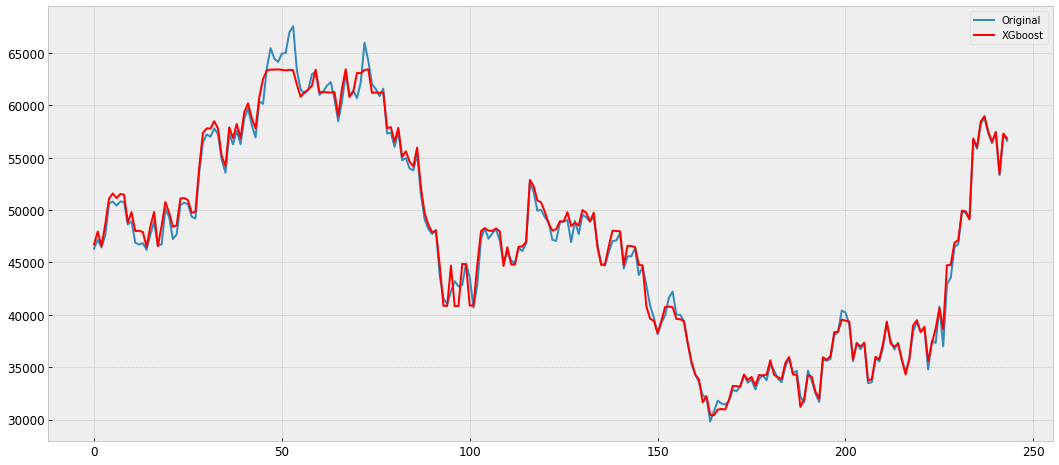

In [ ]:
plt.plot(df_test.Close.values, label='Original')
plt.plot(yhat, color='red', label='XGboost')
plt.legend()

##### Lightgbm

A tree gradient boosting model by microsoft

In [ ]:
lightGBM = lgb.LGBMRegressor()
lightGBM.fit(X_train, y_train)
yhat = lightGBM.predict(X_test)
resultsDict['Lightgbm'] = evaluate(df_test.Close, yhat)
predictionsDict['Lightgbm'] = yhat

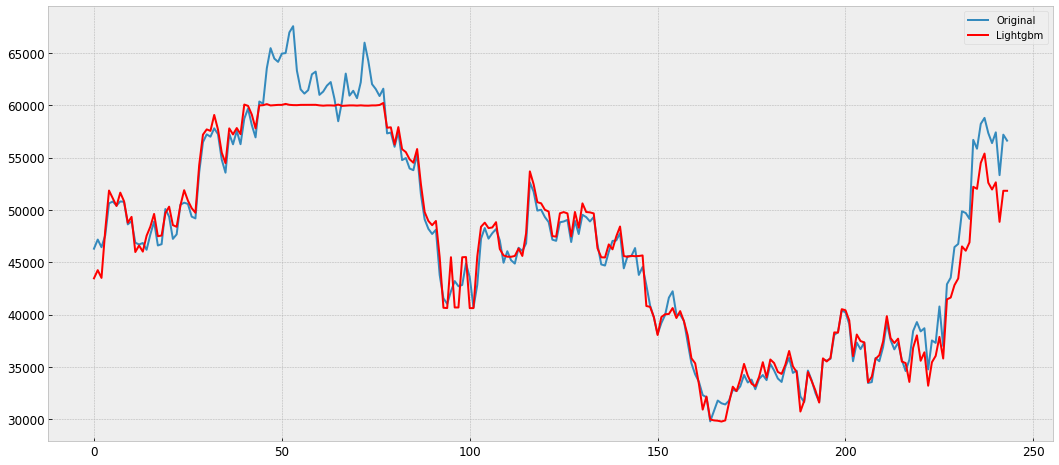

In [ ]:
plt.plot(df_test.Close.values, label='Original')
plt.plot(yhat, color='red', label='Lightgbm')
plt.legend()

##### Support Vector Machines

In [ ]:
reg = svm.SVR(kernel='rbf', C=100, gamma=0.1, epsilon=.1)
reg.fit(X_train, y_train)
yhat = reg.predict(X_test)
resultsDict['SVM RBF'] = evaluate(df_test.Close, yhat)
predictionsDict['SVM RBF'] = yhat

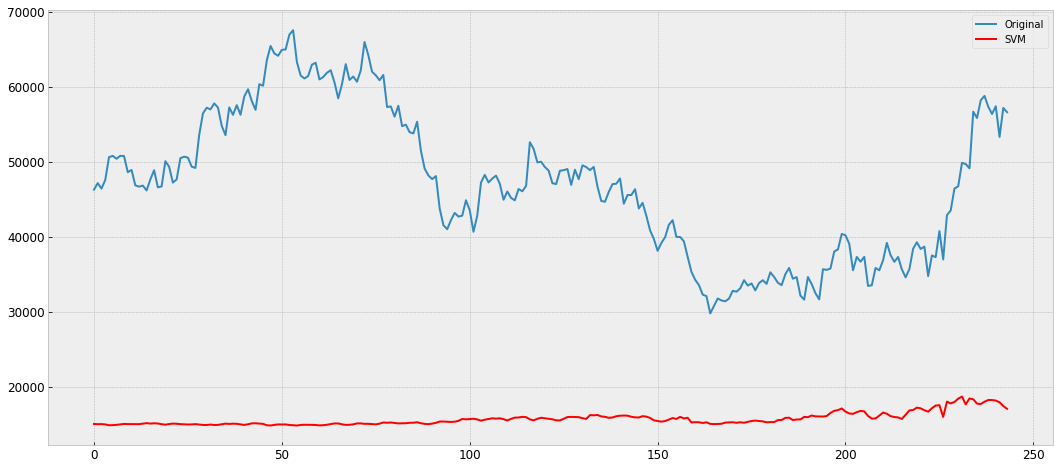

In [ ]:
plt.plot(df_test.Close.values, label='Original')
plt.plot(yhat, color='red', label='SVM')
plt.legend()

##### KNN: K Nearest neighbors

In [ ]:
reg = KNeighborsRegressor(n_neighbors=2)
reg.fit(X_train, y_train)
yhat = reg.predict(X_test)
resultsDict['Kneighbors'] = evaluate(df_test.Close, yhat)
predictionsDict['Kneighbors'] = yhat

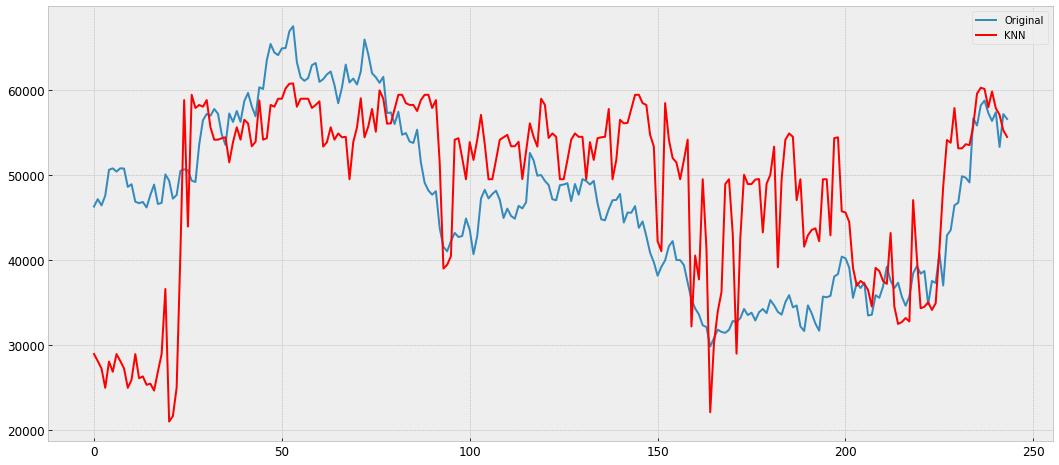

In [ ]:
plt.plot(df_test.Close.values, label='Original')
plt.plot(yhat, color='red', label='KNN')
plt.legend()

#### Prophet multivariate

In [ ]:
prophet = Prophet(
).add_seasonality(
    name='monthly',
    period=30.5,
    fourier_order=55
).add_seasonality(
    name='daily',
    period=1,
    fourier_order=15
).add_seasonality(
    name='weekly',
    period=7,
    fourier_order=25
).add_seasonality(
    name='yearly',
    period=365.25,
    fourier_order=20
).add_seasonality(
    name='quarterly',
    period=365.25/4,
    fourier_order=55
)

for col in prophet_training.columns:
    if col not in ["ds", "y"]:
        prophet.add_regressor(col)

In [ ]:
prophet.fit(prophet_training)
yhat = prophet.predict(prophet_test)
resultsDict['Prophet multivariate'] = evaluate(y_test, yhat.yhat.values)
predictionsDict['Prophet multivariate'] = yhat.yhat.values

INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Found custom seasonality named 'daily', disabling built-in 'daily' seasonality.


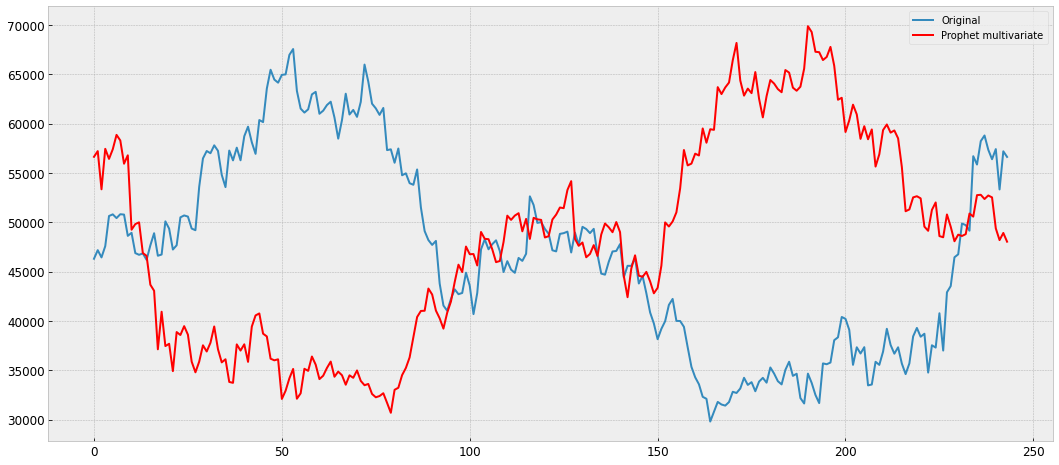

In [ ]:
plt.plot(df_test.Close.values, label='Original')
plt.plot(yhat.yhat, color='red', label='Prophet multivariate')
plt.legend()

### **Deep learning**

#### Tensorlfow LSTM

LSTM are a special type of neural network architecture.

We will be trying a LSTM model for our benchmark but we will need to reshape our data to provide the network a window of previous samples (past days data) for each y target value. Find the code here

In [ ]:
# For our dl model we will create windows of data that will be feeded into the datasets, for each timestemp T we will append the data from T-7 to T to the Xdata with target Y(t)
BATCH_SIZE = 64
BUFFER_SIZE = 100
WINDOW_LENGTH = 24


def window_data(X, Y, window=7):
    '''
    The dataset length will be reduced to guarante all samples have the window, so new length will be len(dataset)-window
    '''
    x = []
    y = []
    for i in range(window-1, len(X)):
        x.append(X[i-window+1:i+1])
        y.append(Y[i])
    return np.array(x), np.array(y)


# Since we are doing sliding, we need to join the datasets again of train and test
X_w = np.concatenate((X_train, X_test))
y_w = np.concatenate((y_train, y_test))

X_w, y_w = window_data(X_w, y_w, window=WINDOW_LENGTH)
X_train_w = X_w[:-len(X_test)]
y_train_w = y_w[:-len(X_test)]
X_test_w = X_w[-len(X_test):]
y_test_w = y_w[-len(X_test):]

# Check we will have same test set as in the previous models, make sure we didnt screw up on the windowing
print(f"Test set equal: {np.array_equal(y_test_w,y_test)}")

train_data = tf.data.Dataset.from_tensor_slices((X_train_w, y_train_w))
train_data = train_data.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data = tf.data.Dataset.from_tensor_slices((X_test_w, y_test_w))
val_data = val_data.batch(BATCH_SIZE).repeat()

Test set equal: True


In [ ]:
dropout = 0.0
simple_lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(
        128, input_shape=X_train_w.shape[-2:], dropout=dropout),
    tf.keras.layers.Dense(128),
    tf.keras.layers.Dense(128),
    tf.keras.layers.Dense(1)
])

simple_lstm_model.compile(optimizer='rmsprop', loss='mae')

# logdir = "logs/scalars/" + datetime.now().strftime("%Y%m%d-%H%M%S") #Support for tensorboard tracking!
# tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [ ]:
EVALUATION_INTERVAL = 1000
EPOCHS = 10

model_history = simple_lstm_model.fit(train_data, epochs=EPOCHS,
                                      steps_per_epoch=EVALUATION_INTERVAL,
                                      validation_data=val_data, validation_steps=50)  # ,callbacks=[tensorboard_callback]) #Uncomment this line for tensorboard support

Epoch 1/10
1000/1000 [==============================] - 45s 43ms/step - loss: 3940.6096 - val_loss: 9159.6035
Epoch 2/10
1000/1000 [==============================] - 42s 42ms/step - loss: 661.1248 - val_loss: 13316.5840
Epoch 3/10
1000/1000 [==============================] - 42s 42ms/step - loss: 479.5167 - val_loss: 19368.7148
Epoch 4/10
1000/1000 [==============================] - 42s 42ms/step - loss: 389.1747 - val_loss: 24523.6094
Epoch 5/10
1000/1000 [==============================] - 42s 42ms/step - loss: 313.3569 - val_loss: 24058.9551
Epoch 6/10
1000/1000 [==============================] - 42s 42ms/step - loss: 270.3603 - val_loss: 23753.8457
Epoch 7/10
1000/1000 [==============================] - 42s 42ms/step - loss: 246.0233 - val_loss: 22451.4766
Epoch 8/10
1000/1000 [==============================] - 42s 42ms/step - loss: 222.7262 - val_loss: 25440.8770
Epoch 9/10
1000/1000 [==============================] - 42s 42ms/step - loss: 207.0853 - val_loss: 25950.1074
Epoch 10/1

In [ ]:
yhat = simple_lstm_model.predict(X_test_w).reshape(1, -1)[0]
resultsDict['Tensorflow simple LSTM'] = evaluate(y_test, yhat)
predictionsDict['Tensorflow simple LSTM'] = yhat

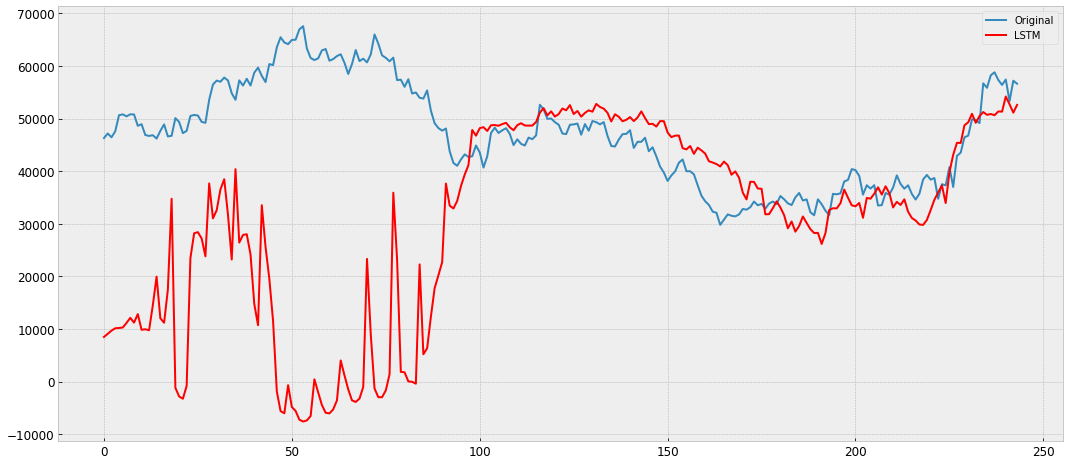

In [ ]:
plt.plot(df_test.Close.values, label='Original')
plt.plot(yhat, color='red', label='LSTM')
plt.legend()

#### DeepAR

It is a deep learning architecture released by amazon

In [ ]:
features = ['Open', 'High', 'Low', 'Volume', 'Market Cap', 'Typical_Price', 
            'TP_by_Volume', 'Weighted_Price', 'hour', 'dayofweek',
            'quarter', 'month', 'year', 'dayofyear', 'sin_day', 'cos_day',
            'dayofmonth', 'weekofyear']

scaler = StandardScaler()
scaler.fit(X_train)  # No cheating, never scale on the training+test!
df_training[features] = scaler.transform(df_training[features])
df_test[features] = scaler.transform(df_test[features])


training_data = ListDataset(
    [{"start": df_training.index[0], "target": df_training.Close,
      'feat_dynamic_real': [df_training[feature] for feature in features]
      }],
    freq="d"
)
test_data = ListDataset(
    [{"start": df_test.index[0], "target": df_test.Close,
      'feat_dynamic_real': [df_test[feature] for feature in features]
      }],
    freq="d"
)

In [ ]:
estimator = DeepAREstimator(freq="d",
                            prediction_length=1, context_length=30,
                            trainer=Trainer(epochs=5))

predictor = estimator.train(training_data=training_data)


forecast_it, ts_it = make_evaluation_predictions(
    test_data, predictor=predictor, num_samples=len(df_test))

forecasts = list(forecast_it)
tss = list(ts_it)

INFO:gluonts.trainer:Start model training
INFO:gluonts.trainer:Epoch[0] Learning rate is 0.001
100%|██████████| 50/50 [00:03<00:00, 12.74it/s, epoch=1/5, avg_epoch_loss=9.65]
INFO:gluonts.trainer:Epoch[0] Elapsed time 3.935 seconds
INFO:gluonts.trainer:Epoch[0] Evaluation metric 'epoch_loss'=9.647050
INFO:gluonts.trainer:Epoch[1] Learning rate is 0.001
100%|██████████| 50/50 [00:03<00:00, 13.65it/s, epoch=2/5, avg_epoch_loss=8.59]
INFO:gluonts.trainer:Epoch[1] Elapsed time 3.669 seconds
INFO:gluonts.trainer:Epoch[1] Evaluation metric 'epoch_loss'=8.594726
INFO:gluonts.trainer:Epoch[2] Learning rate is 0.001
100%|██████████| 50/50 [00:03<00:00, 13.44it/s, epoch=3/5, avg_epoch_loss=8.46]
INFO:gluonts.trainer:Epoch[2] Elapsed time 3.725 seconds
INFO:gluonts.trainer:Epoch[2] Evaluation metric 'epoch_loss'=8.457302
INFO:gluonts.trainer:Epoch[3] Learning rate is 0.001
100%|██████████| 50/50 [00:03<00:00, 13.31it/s, epoch=4/5, avg_epoch_loss=8.29]
INFO:gluonts.trainer:Epoch[3] Elapsed time 3.

In [ ]:
yhat = forecasts[0].samples.reshape(1, -1)[0]
resultsDict['DeepAR'] = evaluate(y_test, yhat)
predictionsDict['DeepAR'] = yhat

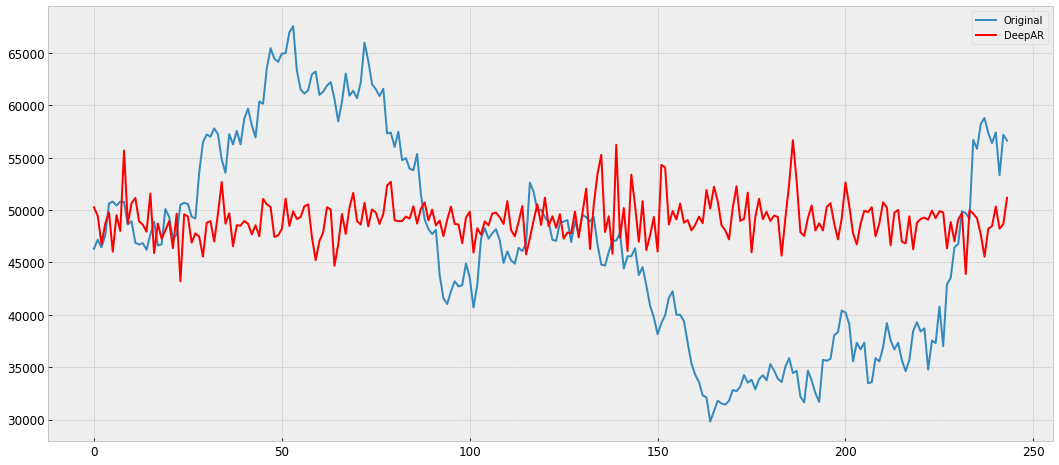

In [ ]:
plt.plot(df_test.Close.values, label='Original')
plt.plot(yhat, color='red', label='DeepAR')
plt.legend()

### **Hyperparameter optimization**

Hyperparameter optimization is trying to find the best parameters in an automatic way. We present two methods that are used frequently:


*   Grid search Brute force method to try all different possible combinations of parameters. Will always find the best combination
*   Bayesian processes "Brute" force method, optimizes parameter search by using gausian processes to model each parameter distribution and don't go over all the possible values.

#### Grid search - SVM

In [ ]:
reg = GridSearchCV(svm.SVR(kernel='rbf', gamma=0.1),
                   param_grid={"C": [1e0, 1e1, 1e2, 1e3],
                               "gamma": np.logspace(-2, 2, 5)})
reg.fit(X_train, y_train)
yhat = reg.predict(X_test)
resultsDict['SVM RBF GRID SEARCH'] = evaluate(df_test.Close, yhat)
predictionsDict['SVM RBF GRID SEARCH'] = yhat

In [ ]:
increase = 1 - (resultsDict['SVM RBF GRID SEARCH']
                ['rmse']/resultsDict['SVM RBF']['rmse'])
print(
    f"Grid search Tunned SVM is {increase*100}% better than the SVM with default parameters")

Grid search Tunned SVM is 82.37074317138477% better than the SVM with default parameters


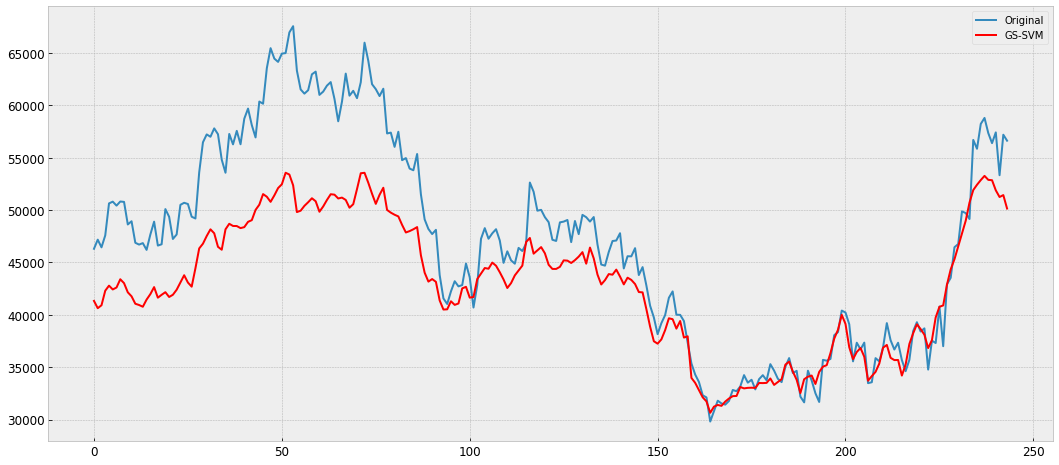

In [ ]:
plt.plot(df_test.Close.values, label='Original')
plt.plot(yhat, color='red', label='GS-SVM')
plt.legend()

#### Bayesian processes - RandomForestRegressor

In [ ]:
def rms(y_actual, y_predicted):
    return sqrt(mean_squared_error(y_actual, y_predicted))


my_scorer = make_scorer(rms, greater_is_better=False)
pbounds = {
    'n_estimators': (100, 10000),
    'max_depth': (3, 15),
    'min_samples_leaf': (1, 4),
    'min_samples_split': (2, 10),
}


def rf_hyper_param(n_estimators,
                   max_depth,
                   min_samples_leaf,
                   min_samples_split):

    max_depth = int(max_depth)
    n_estimators = int(n_estimators)

    clf = RandomForestRegressor(n_estimators=n_estimators,
                                max_depth=int(max_depth),
                                min_samples_leaf=int(min_samples_leaf),
                                min_samples_split=int(min_samples_split),
                                n_jobs=1)

    return -np.mean(cross_val_score(clf, X_train, y_train, cv=3))


optimizer = BayesianOptimization(
    f=rf_hyper_param,
    pbounds=pbounds,
    random_state=1,
)

In [ ]:
optimizer.maximize(
    init_points=3,
    n_iter=20,
    acq='ei'
)

|   iter    |  target   | max_depth | min_sa... | min_sa... | n_esti... |
-------------------------------------------------------------------------
|  1        |  1.368    |  8.004    |  3.161    |  2.001    |  3.093e+0 |
|  2        |  1.648    |  4.761    |  1.277    |  3.49     |  3.521e+0 |
|  3        |  1.373    |  7.761    |  2.616    |  5.354    |  6.884e+0 |
|  4        |  1.586    |  4.298    |  3.175    |  5.441    |  3.52e+03 |
|  5        |  1.298    |  10.33    |  1.133    |  3.35     |  3.523e+0 |
|  6        |  1.635    |  4.598    |  2.344    |  4.794    |  3.52e+03 |
|  7        |  2.281    |  3.944    |  1.561    |  4.268    |  3.512e+0 |
|  8        |  1.399    |  8.198    |  3.784    |  3.04     |  3.511e+0 |
|  9        |  1.379    |  5.122    |  1.064    |  2.379    |  3.516e+0 |
|  10       |  1.584    |  5.454    |  1.28     |  4.171    |  3.509e+0 |
|  11       |  1.547    |  4.919    |  2.553    |  3.356    |  3.514e+0 |
|  12       |  1.507    |  6.627    | 

In [ ]:
params = optimizer.max['params']

# Converting the max_depth and n_estimator values from float to int
params['max_depth'] = int(params['max_depth'])
params['n_estimators'] = int(params['n_estimators'])
params['min_samples_leaf'] = int(params['min_samples_leaf'])
params['min_samples_split'] = int(params['min_samples_split'])

# Initialize an XGBRegressor with the tuned parameters and fit the training data
tunned_rf = RandomForestRegressor(**params)
# Change verbose to True if you want to see it train
tunned_rf.fit(X_train, y_train)

yhat = tunned_rf.predict(X_test)
resultsDict['Randomforest tunned'] = evaluate(y_test, yhat)
predictionsDict['Randomforest tunned'] = yhat

In [ ]:
increase = 1 - (resultsDict['Randomforest tunned']
                ['rmse']/resultsDict['Randomforest']['rmse'])
print(
    f"Bayesian optimized Randomforest is {increase*100}% better than the Randomforest with default parameters")

Bayesian optimized Randomforest is 51.986629345926616% better than the Randomforest with default parameters


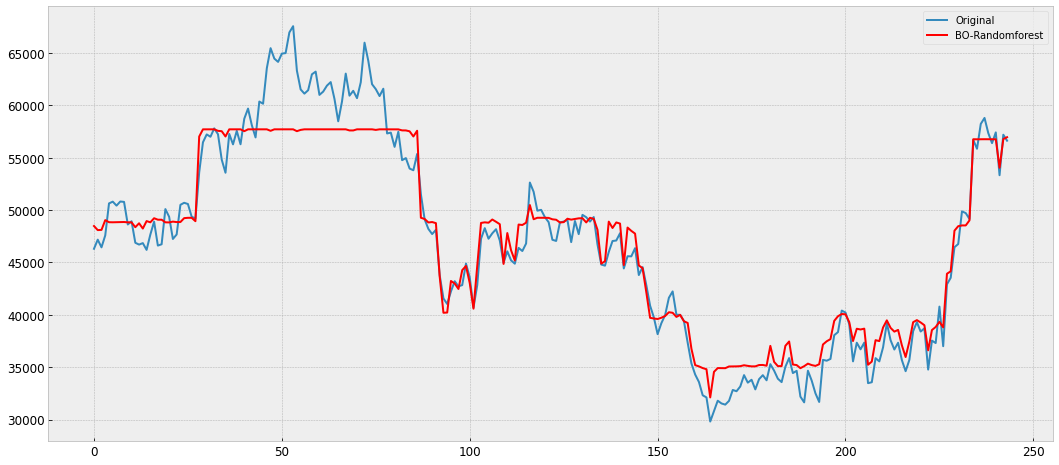

In [ ]:
plt.plot(df_test.Close.values, label='Original')
plt.plot(yhat, color='red', label='BO-Randomforest')
plt.legend()

### **Ensembling**

Ensembling refers to combine multiple models to achieve a better performance, most of the time this only makes sense when models have similar performance but predict values differently so we try to get the best of each model.

We will pick our 3 top performing models and look at the correlation of their residuals, the less correlated the better

In [ ]:
models = ['Lasso','Randomforest','XGBoost','Lightgbm','SVM RBF GRID SEARCH','Randomforest tunned']
resis = pd.DataFrame(data={k: df_test.Close.values -
                     v for k, v in predictionsDict.items()})[models]
corr = resis.corr()
print("Residuals correlation")
corr.style.background_gradient(cmap='coolwarm')

Residuals correlation


In [ ]:
predictionsDict['Randomforest tunned+LIGHT'] = (
    predictionsDict['Randomforest tunned'] + predictionsDict['Lightgbm'])/2
resultsDict['Randomforest tunned+LIGHT'] = evaluate(
    df_test.Close.values, predictionsDict['Randomforest tunned+LIGHT'])

predictionsDict['Randomforest tunned+LIGHT+XGBoost'] = (predictionsDict['Randomforest tunned'] +
                                          predictionsDict['Lightgbm'] + predictionsDict['XGBoost'])/3
resultsDict['Randomforest tunned+LIGHT+XGBoost'] = evaluate(
    df_test.Close.values, predictionsDict['Randomforest tunned+LIGHT+XGBoost'])

predictionsDict['EnsembleLIGHT+XGBoost'] = (
    predictionsDict['Lightgbm'] + predictionsDict['XGBoost'])/2
resultsDict['EnsembleLIGHT+XGBoost'] = evaluate(
    df_test.Close.values, predictionsDict['EnsembleLIGHT+XGBoost'])

predictionsDict['Randomforest tunned+XGBoost'] = (predictionsDict['Randomforest tunned'] +
                                    predictionsDict['XGBoost'])/2
resultsDict['Randomforest tunned+XGBoost'] = evaluate(
    df_test.Close.values, predictionsDict['Randomforest tunned+XGBoost'])

In [ ]:
def full_extent(ax, pad=0.0):
    """Get the full extent of an axes, including axes labels, tick labels, and
    titles."""
    # For text objects, we need to draw the figure first, otherwise the extents
    # are undefined.
    ax.figure.canvas.draw()
    items = ax.get_xticklabels() + ax.get_yticklabels()
#    items += [ax, ax.title, ax.xaxis.label, ax.yaxis.label]
    items += [ax, ax.title]
    bbox = Bbox.union([item.get_window_extent() for item in items])

    return bbox.expanded(1.0 + pad, 1.0 + pad)

# **Model Final Understanding and Feature importance**

In [ ]:
pd.DataFrame.from_dict(resultsDict).T.reset_index().rename(columns={'index':'model_name'}).sort_values("r2",ascending=False)

model_name           mae  ...      mape         r2
9                                Lasso    367.815516  ...  0.008012   0.996996
11                             XGBoost    588.051254  ...  0.012361   0.992400
22               EnsembleLIGHT+XGBoost    817.408681  ...  0.016514   0.985231
21   Randomforest tunned+LIGHT+XGBoost    989.192827  ...  0.019998   0.978234
23         Randomforest tunned+XGBoost   1072.915421  ...  0.022569   0.976777
12                            Lightgbm   1248.384125  ...  0.025142   0.963906
20           Randomforest tunned+LIGHT   1318.879845  ...  0.026575   0.961898
19                 Randomforest tunned   1808.720756  ...  0.038008   0.935216
10                        Randomforest   4443.636502  ...  0.094726   0.718974
18                 SVM RBF GRID SEARCH   4325.192633  ...  0.081087   0.643632
17                              DeepAR   8520.649396  ...  0.200081  -0.119766
14                          Kneighbors   8228.269166  ...  0.189391  -0.154500
8                        BayesianRidge  14116.116111  ...  0.282867  -2.337151
15                Prophet multivariate  15338.719719  ...  0.353240  -2.875151
7                   Prophet univariate  17467.139865  ...  0.435410  -3.563049
0                           Naive mean  26599.353440  ...  0.546862  -7.550046
16              Tensorflow simple LSTM  19531.552710  ...  0.363736  -8.507517
13                             SVM RBF  31244.496201  ...  0.649441 -10.466484
3                                ARIMA  37859.560205  ...  0.800054 -15.216943
1                                  SES  37938.193445  ...  0.801752 -15.282322
2                                 HWES  37938.202419  ...  0.801752 -15.282331
4                  AutoARIMA (2, 1, 3)           NaN  ...       NaN -15.283957
6   AutoSARIMAX (2, 1, 2),(1, 0, 1, 6)  37940.725968  ...  0.801789 -15.285403
5                              SARIMAX  37947.550774  ...  0.801949 -15.290272

[24 rows x 5 columns]

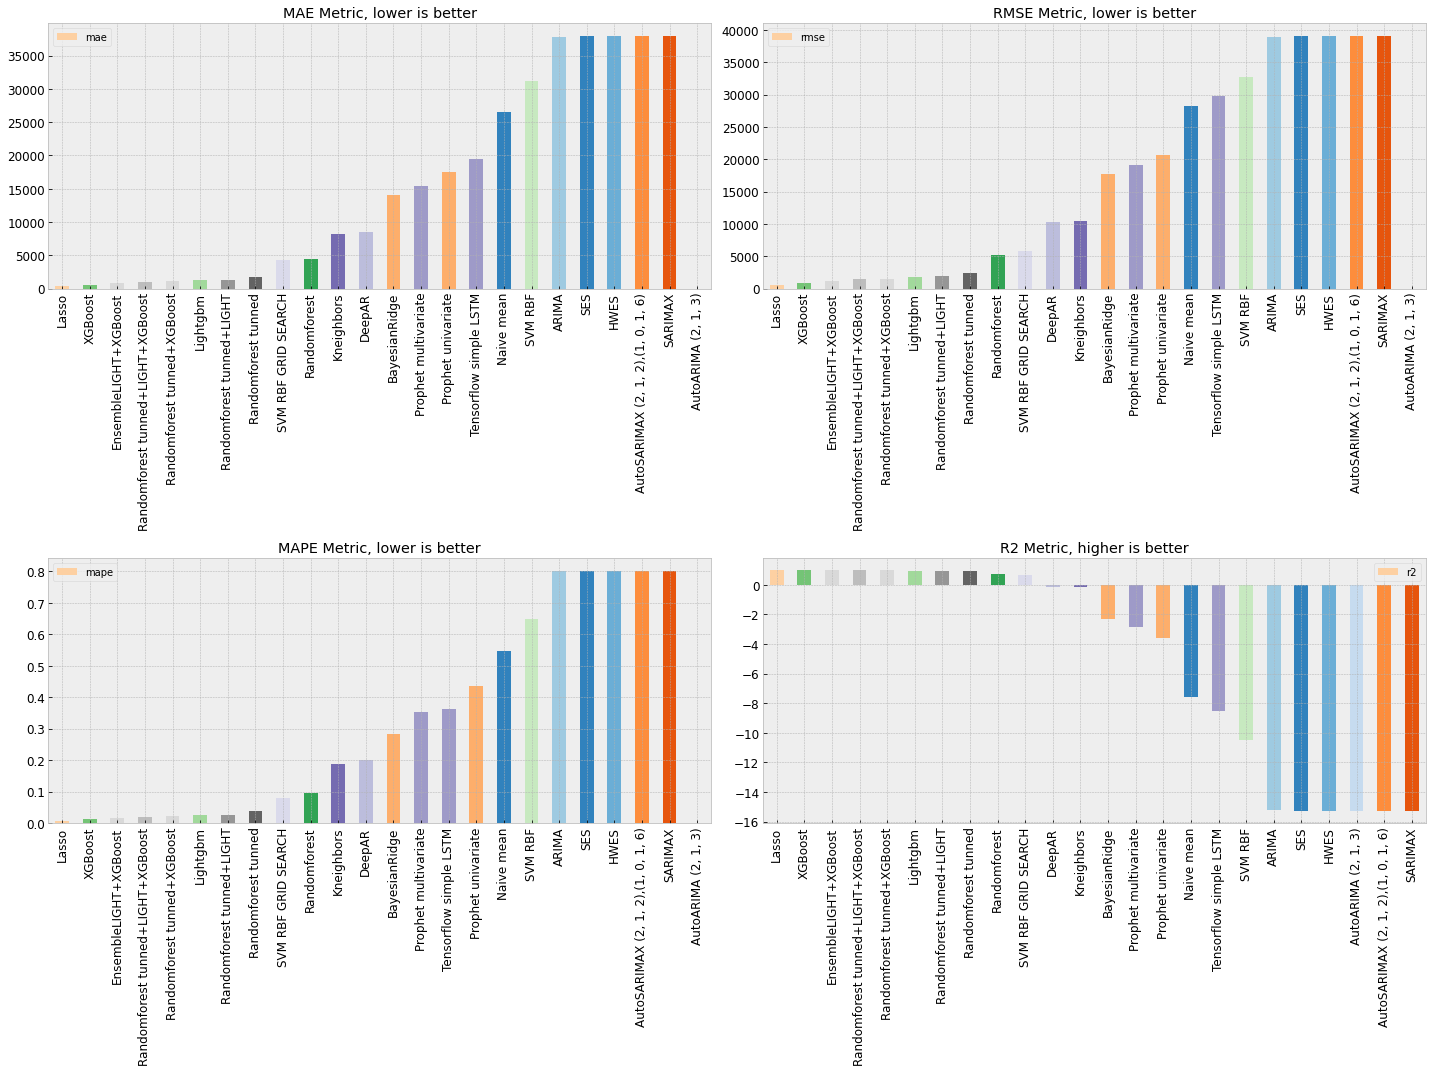

In [ ]:
bar_metrics(resultsDict)

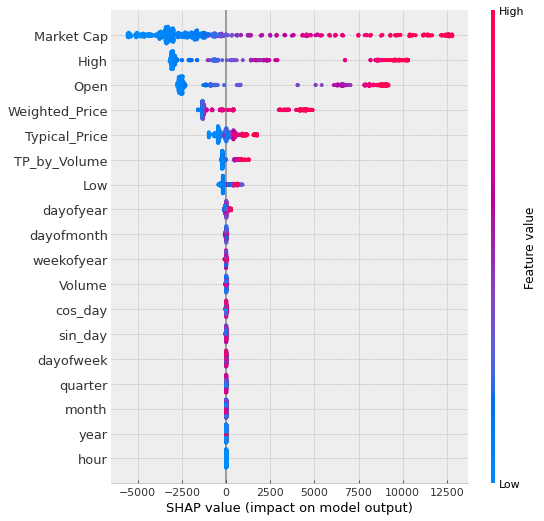

In [ ]:
explainer = shap.TreeExplainer(lightGBM)
shap_values = explainer.shap_values(X_train_df)
shap.summary_plot(shap_values, X_train_df)

# **Links**

Volume-Weighted Average Price (VWAP) - https://academy.binance.com/en/articles/volume-weighted-average-price-vwap-explained

Holt Winter’s Exponential Smoothing - https://machinelearningmastery.com/how-to-grid-search-triple-exponential-smoothing-for-time-series-forecasting-in-python/

Auto-Arima - https://alkaline-ml.com/pmdarima/tips_and_tricks.html

Prophet - https://github.com/facebook/prophet

Lightgbm - https://github.com/microsoft/LightGBM

LSTM - https://www.tensorflow.org/guide/keras/rnn

DeepAR - https://arxiv.org/pdf/1704.04110.pdf

Feature importance(Shap) - https://github.com/slundberg/shap